In [38]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib.ticker as mtick

fred = Fred(api_key="672d5598c8a41df9397cc5eb92c02d5e")

def anualizar(df, titulo="Título padrão", ylim=(-0.02, 0.07)):
    # você tem que me entregar um data frame com a série SA com '"Pct Change from a year ago"', em que eu preciso dos dados desde 2010 até hoje
    df["3 MMA"] = df["Pct Change"].rolling(window=3).mean()
    df["6 MMA"] = df["Pct Change"].rolling(window=6).mean()
    df["3 MMA SAAR"] = (df["3 MMA"] + 1) ** 12 - 1
    df["6 MMA SAAR"] = (df["6 MMA"] + 1) ** 12 - 1  
    # agora dados from a year ago
    goods_graph_values_ya = df[(df.index.year >= 2009)]
    mma3_goods = df["3 MMA SAAR"]
    mma6_goods = df["6 MMA SAAR"]
    mma12_goods = goods_graph_values_ya["Pct Change from a year ago"]
    mean_10_19_goods = df[(df.index.year >= 2010) & (df.index.year <= 2019)]["Pct Change from a year ago"].mean()

    goods_ya = pd.DataFrame({
        "MMA3": mma3_goods,
        "MMA6": mma6_goods,
        "MMA12": mma12_goods,
        "Mean 2010-2019": mean_10_19_goods
    })

    goods_ya.dropna(inplace=True)
    goods_ya = goods_ya.drop(goods_ya.index[0])

    fig, ax = plt.subplots(figsize=(15,9))

    ax.plot(goods_ya.index, goods_ya["MMA3"], linewidth=2, color="#AFABAB", label="3 MMA SAAR", ls=":")
    ax.plot(goods_ya.index, goods_ya["MMA6"], linewidth=2, color="#37A6D9", label="6 MMA SAAR", ls="--")
    ax.plot(goods_ya.index, goods_ya["MMA12"], linewidth=2, color="#082631", label="YoY %")
    ax.plot(goods_ya.index, goods_ya["Mean 2010-2019"], linewidth=2, color="#166083", label="Mean (2010-2019)")

    fig.suptitle(titulo, fontsize=28, fontweight='bold')
    ax.set_title("SA Pct Change YoY %", fontsize=18)
    ax.legend(frameon=False, fontsize=18, loc="upper left")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#c0c0c0")
    ax.spines["bottom"].set_color("#c0c0c0")

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    ax.text(goods_ya.index[-1], goods_ya["MMA3"].iloc[-1], f'{goods_ya["MMA3"].iloc[-1]:.2%}', color="#AFABAB", fontsize=14, ha='left')
    ax.text(goods_ya.index[-1], goods_ya["MMA6"].iloc[-1], f'{goods_ya["MMA6"].iloc[-1]:.2%}', color="#37A6D9", fontsize=14, ha='left')
    ax.text(goods_ya.index[-1], goods_ya["MMA12"].iloc[-1], f'{goods_ya["MMA12"].iloc[-1]:.2%}', color="#082631", fontsize=14, ha='left')
    ax.text(goods_ya.index[-1], goods_ya["Mean 2010-2019"].iloc[-1], f'{goods_ya["Mean 2010-2019"].iloc[-1]:.2%}', color="#166083", fontsize=14, ha='left')
    ax.set_ylim(ylim)
    ax.set_xlabel("Fonte: FRED | Impactus UFRJ", fontsize=18, labelpad=15)

    fig.tight_layout()

    return fig
def dessazonalizar(df, titulo="Título padrão"):

    # você tem que me entregar um data frame com a série NSA com 'Pct Change', em que eu preciso dos dados desde 2010 até hoje
    df_24 = df[df.index.year == 2024]
    df_25 = df[df.index.year == 2025]
    df = df[(df.index.year >= 2010) & (df.index.year <= 2019)]
    percentil_10 = pd.DataFrame()
    percentil_90 = pd.DataFrame()

    for mes in range(1, 13):
        dados_mes = df[df.index.month == mes]["Pct Change"]
        percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
        percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

    valores_2024 = []
    valores_2025 = []
    
    for mes in range(1, 13):
        valor_24 = df_24[df_24.index.month == mes]["Pct Change"].values
        valor_25 = df_25[df_25.index.month == mes]["Pct Change"].values
        valores_2024.append(valor_24[0] if len(valor_24) > 0 else None)
        valores_2025.append(valor_25[0] if len(valor_25) > 0 else None)

    valores_dos_graficos = pd.DataFrame()
    valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
    valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
    valores_dos_graficos["Ano de 2024"] = valores_2024
    valores_dos_graficos["Ano de 2025"] = valores_2025
    valores_dos_graficos["Mediana"] = df.groupby(df.index.month)["Pct Change"].median()
    valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    fig, ax = plt.subplots(figsize=(18, 10.8))

    ax.fill_between(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], valores_dos_graficos["Percentil 90"], 
                    color="grey", alpha=0.3, label="10th-90th (2010-2019)")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")


    fig.suptitle(titulo, fontsize=26, fontweight='bold')
    ax.legend(frameon=False, fontsize=14, loc="upper right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#d9d9d9")
    ax.spines["bottom"].set_color("#d9d9d9")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    ax.set_xlabel("Fonte: FRED | Impactus UFRJ", fontsize=14, labelpad=15)
    fig.tight_layout()


    return fig  
def sa_main(df,titulo="Título padrão"):
    df_24 = df[df.index.year == 2024]
    df_25 = df[df.index.year == 2025]
    df = df[(df.index.year >= 2010) & (df.index.year <= 2019)]
    percentil_10 = pd.DataFrame()
    percentil_90 = pd.DataFrame()

    for mes in range(1, 13):
        dados_mes = df[df.index.month == mes]["Pct Change"]
        percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
        percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

    valores_2024 = []
    valores_2025 = []
    
    for mes in range(1, 13):
        valor_24 = df_24[df_24.index.month == mes]["Pct Change"].values
        valor_25 = df_25[df_25.index.month == mes]["Pct Change"].values
        valores_2024.append(valor_24[0] if len(valor_24) > 0 else None)
        valores_2025.append(valor_25[0] if len(valor_25) > 0 else None)

    valores_dos_graficos = pd.DataFrame()
    valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
    valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
    valores_dos_graficos["Ano de 2024"] = valores_2024
    valores_dos_graficos["Ano de 2025"] = valores_2025
    valores_dos_graficos["Mediana"] = df.groupby(df.index.month)["Pct Change"].median()
    valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    fig, ax = plt.subplots(figsize=(18, 10.8))

    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], linestyle="dotted", linewidth=2, color="black", label="10th Percentile")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Percentil 90"], linestyle="dotted", linewidth=2, color="black", label="90th Percentile")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"],linewidth=2, color="#082631", label="Median")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    ax.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")


    fig.suptitle(titulo, fontsize=26, fontweight='bold')
    ax.legend(frameon=False, fontsize=14, loc="upper right")

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_color("#d9d9d9")
    ax.spines["bottom"].set_color("#d9d9d9")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    ax.set_xlabel("Fonte: FRED | Impactus UFRJ", fontsize=14, labelpad=15)
    fig.tight_layout()


    return fig  

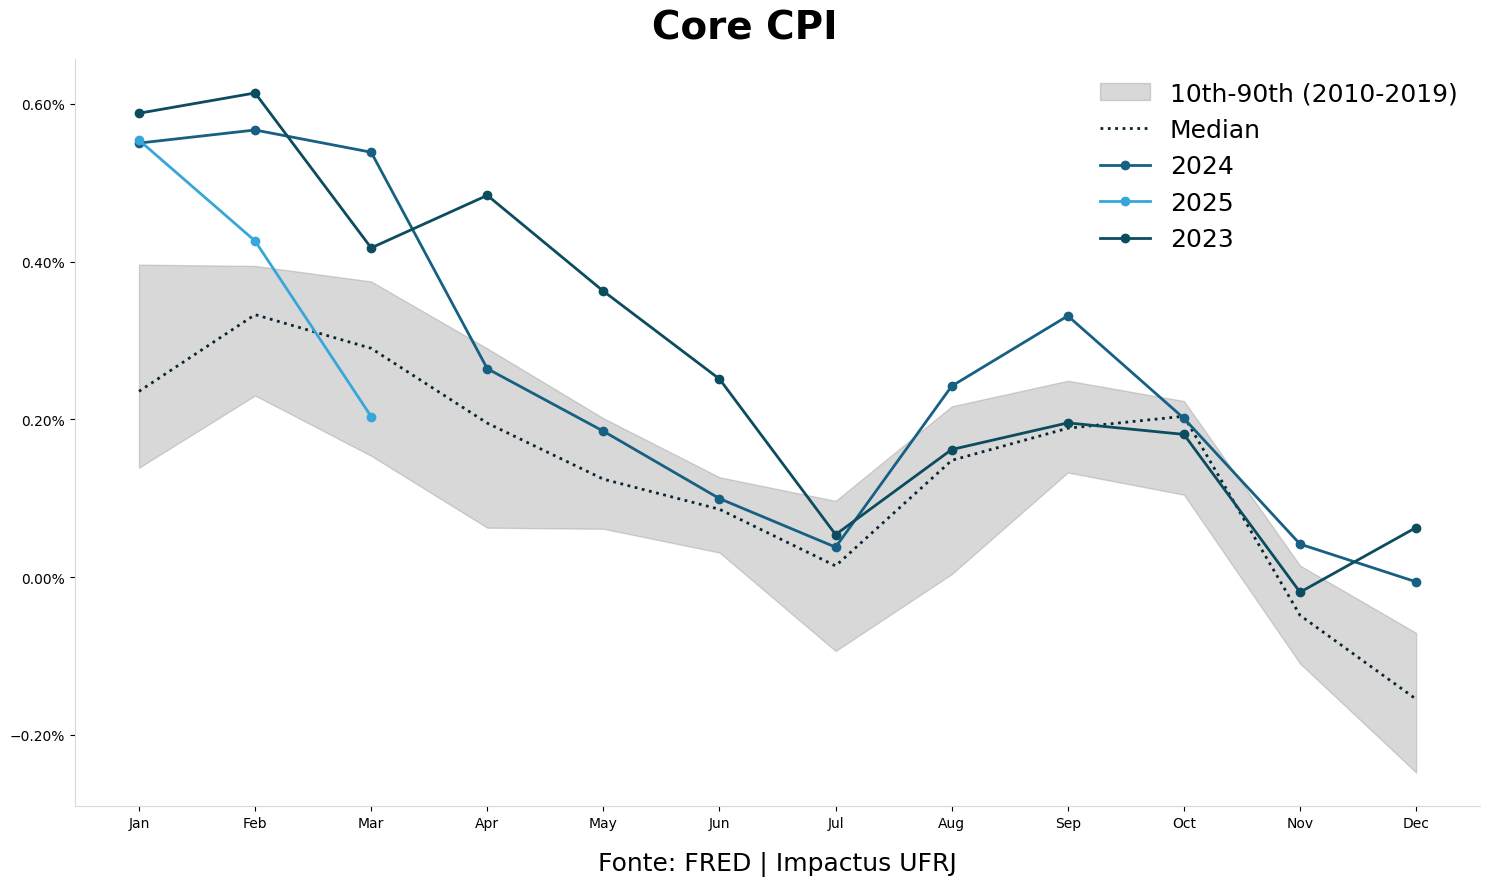

In [33]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm
import matplotlib.ticker as mtick

fred = Fred(api_key="672d5598c8a41df9397cc5eb92c02d5e")

pc = fred.get_series("SUUR0000SA0L1E")
core_cpi = pd.DataFrame()
core_cpi["Nível de preços do núcleo"] = pd.DataFrame(pc)
core_cpi["Pct Change"] = core_cpi['Nível de preços do núcleo'].pct_change()
core_cpi.index = pd.to_datetime(core_cpi.index)

core_cpi_24 = core_cpi[core_cpi.index.year == 2024]
core_cpi_25 = core_cpi[core_cpi.index.year == 2025]
core_cpi_23 = core_cpi[core_cpi.index.year == 2023]

valores_2024 = core_cpi_24.groupby(core_cpi_24.index.month)["Pct Change"].first()
valores_2025 = core_cpi_25.groupby(core_cpi_25.index.month)["Pct Change"].first()
valores_2023 = core_cpi_23.groupby(core_cpi_23.index.month)["Pct Change"].first()

core_cpi = core_cpi[(core_cpi.index.year >= 2010) & (core_cpi.index.year <= 2019)]

percentil_10 = pd.DataFrame()
percentil_90 = pd.DataFrame()

for mes in range(1, 13):
    dados_mes = core_cpi[core_cpi.index.month == mes]["Pct Change"]
    percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
    percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

valores_2024 = []
valores_2025 = []

for mes in range(1, 13):
    valor_24 = core_cpi_24[core_cpi_24.index.month == mes]["Pct Change"].values
    valor_25 = core_cpi_25[core_cpi_25.index.month == mes]["Pct Change"].values
    valores_2024.append(valor_24[0] if len(valor_24) > 0 else None)
    valores_2025.append(valor_25[0] if len(valor_25) > 0 else None)

valores_dos_graficos = pd.DataFrame()
valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
valores_dos_graficos["Ano de 2024"] = valores_2024
valores_dos_graficos["Ano de 2025"] = valores_2025
valores_dos_graficos["Ano de 2023"] = valores_2023
valores_dos_graficos["Mediana"] = core_cpi.groupby(core_cpi.index.month)["Pct Change"].median()
valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(15,9))

plt.fill_between(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], valores_dos_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
plt.suptitle("Core CPI", fontsize=28, fontweight='bold')
plt.legend(frameon=False, fontsize=18, loc="upper right")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("#d9d9d9")
plt.gca().spines["bottom"].set_color("#d9d9d9")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.xlabel("Fonte: FRED | Impactus UFRJ", fontsize=18, labelpad=15)
plt.tight_layout()
plt.show()

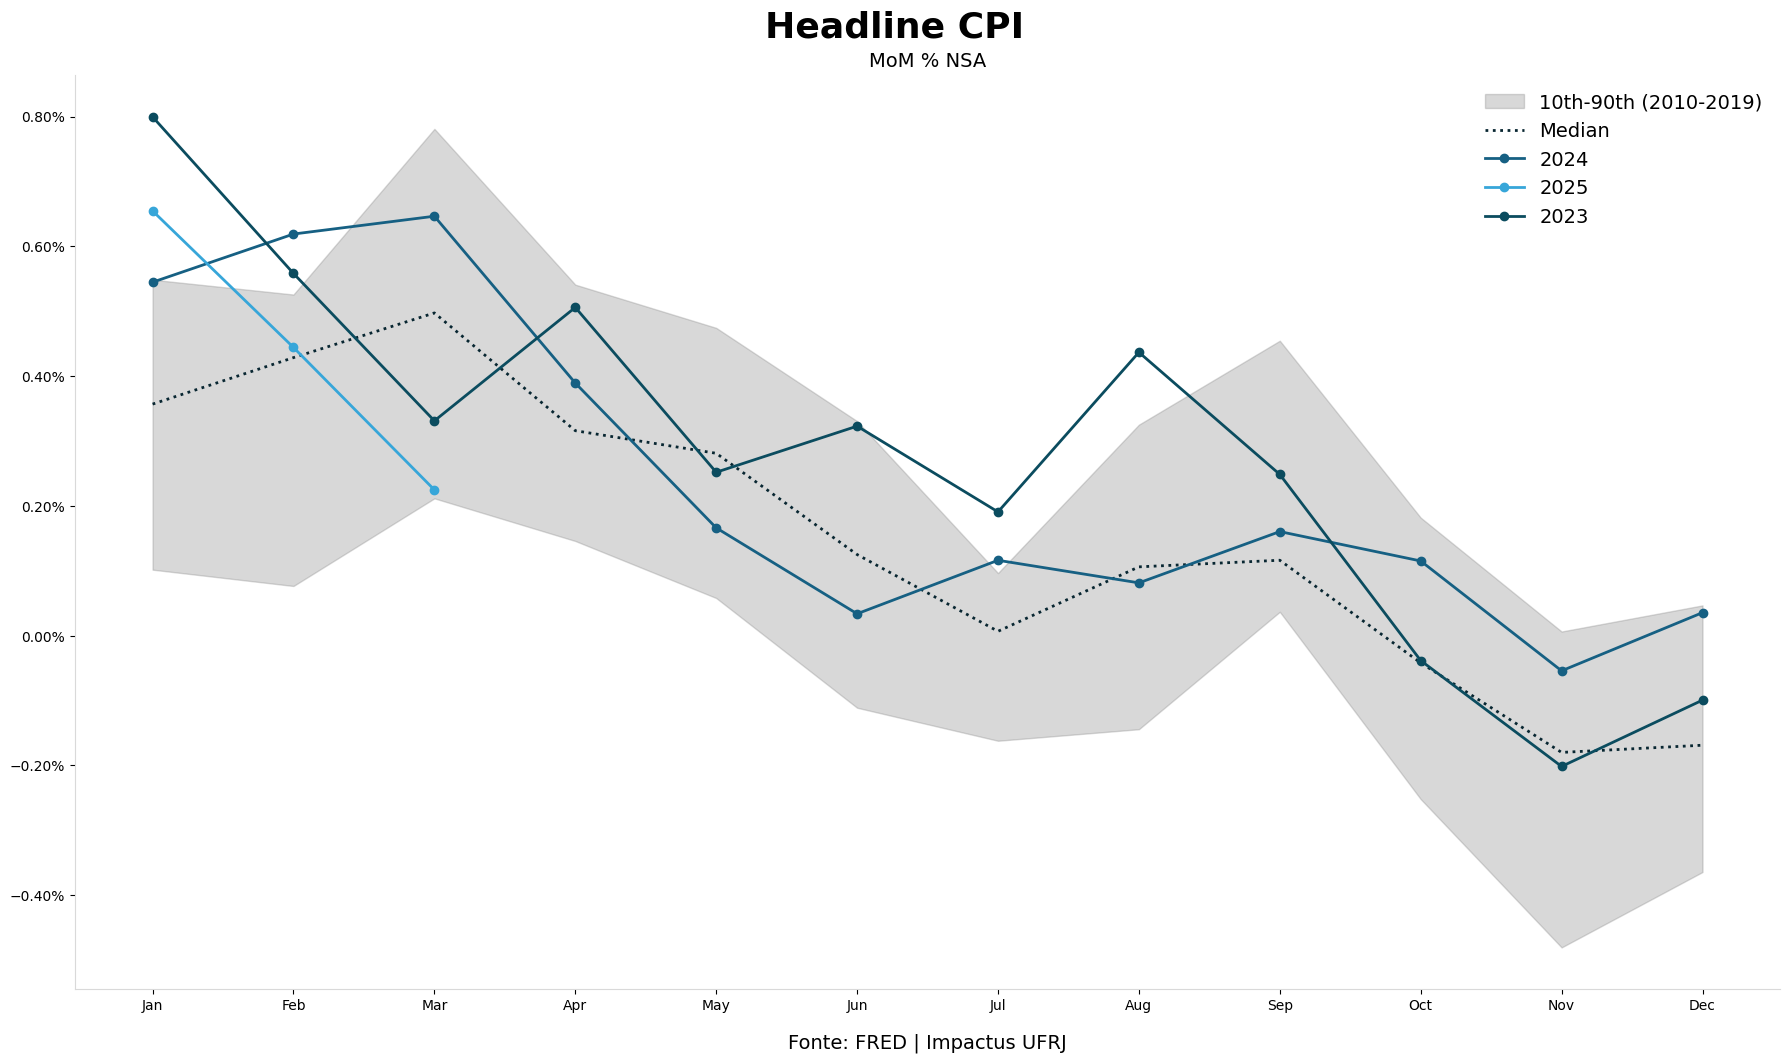

In [19]:
# headline cpi

cpi = fred.get_series('CPIAUCNS')
cpi_us = pd.DataFrame()
cpi_us["MoM %"] = pd.DataFrame(cpi).pct_change()

cpi_23 = cpi_us.loc[cpi_us.index.to_series().dt.year == 2023].copy()
cpi_24 = cpi_us.loc[cpi_us.index.to_series().dt.year == 2024].copy()
cpi_25 = cpi_us.loc[cpi_us.index.to_series().dt.year == 2025].copy()

valores_2024 = cpi_24.groupby(cpi_24.index.month)["MoM %"].first()
valores_2025 = cpi_25.groupby(cpi_25.index.month)["MoM %"].first()
valores_2023 = cpi_23.groupby(cpi_23.index.month)["MoM %"].first()

cpi_us = cpi_us[(cpi_us.index.year >= 2010) & (cpi_us.index.year <= 2019)]

percentil_10 = pd.DataFrame()
percentil_90 = pd.DataFrame()

for mes in range(1, 13):
    dados_mes = cpi_us[cpi_us.index.month == mes]["MoM %"]
    percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
    percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

valores_dos_graficos = pd.DataFrame()
valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
valores_dos_graficos["Ano de 2024"] = valores_2024
valores_dos_graficos["Ano de 2025"] = valores_2025
valores_dos_graficos["Ano de 2023"] = valores_2023
valores_dos_graficos["Mediana"] = cpi_us.groupby(cpi_us.index.month)["MoM %"].median()
valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(18, 10.8))

plt.fill_between(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], valores_dos_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
plt.suptitle("Headline CPI", fontsize=26, fontweight='bold')
plt.title("MoM % NSA", fontsize= 14)
plt.legend(frameon=False, fontsize=14, loc="upper right")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("#d9d9d9")
plt.gca().spines["bottom"].set_color("#d9d9d9")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.xlabel("Fonte: FRED | Impactus UFRJ", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

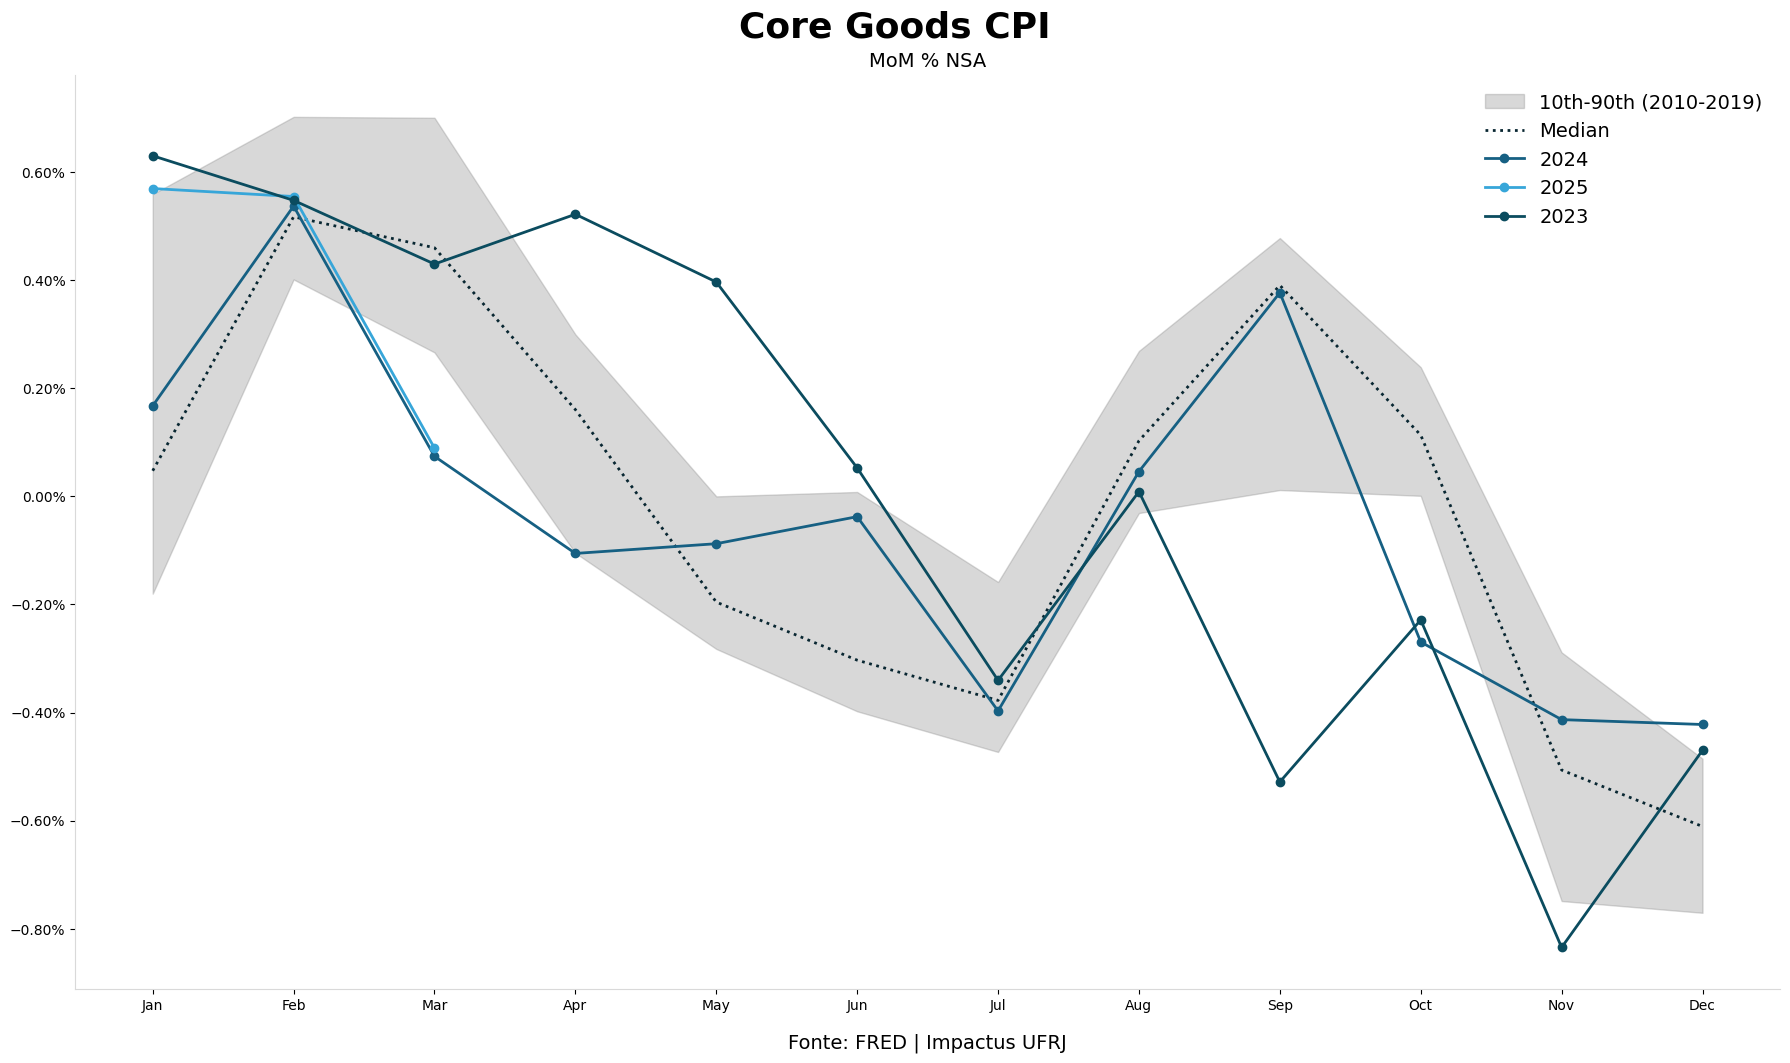

In [20]:
cpi_core_goods = fred.get_series('CUUR0000SACL1E')
cpi_core_goods_us = pd.DataFrame()
cpi_core_goods_us["MoM %"] = pd.DataFrame(cpi_core_goods).pct_change()

cpi_core_goods_23 = cpi_core_goods_us.loc[cpi_core_goods_us.index.to_series().dt.year == 2023].copy()
cpi_core_goods_24 = cpi_core_goods_us.loc[cpi_core_goods_us.index.to_series().dt.year == 2024].copy()
cpi_core_goods_25 = cpi_core_goods_us.loc[cpi_core_goods_us.index.to_series().dt.year == 2025].copy()

valores_2024 = cpi_core_goods_24.groupby(cpi_core_goods_24.index.month)["MoM %"].first()
valores_2025 = cpi_core_goods_25.groupby(cpi_core_goods_25.index.month)["MoM %"].first()
valores_2023 = cpi_core_goods_23.groupby(cpi_core_goods_23.index.month)["MoM %"].first()

cpi_core_goods_us = cpi_core_goods_us[(cpi_core_goods_us.index.year >= 2010) & (cpi_core_goods_us.index.year <= 2019)]

percentil_10 = pd.DataFrame()
percentil_90 = pd.DataFrame()

for mes in range(1, 13):
    dados_mes = cpi_core_goods_us[cpi_core_goods_us.index.month == mes]["MoM %"]
    percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
    percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

valores_dos_graficos = pd.DataFrame()
valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
valores_dos_graficos["Ano de 2024"] = valores_2024
valores_dos_graficos["Ano de 2025"] = valores_2025
valores_dos_graficos["Ano de 2023"] = valores_2023
valores_dos_graficos["Mediana"] = cpi_core_goods_us.groupby(cpi_core_goods_us.index.month)["MoM %"].median()
valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(18, 10.8))

plt.fill_between(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], valores_dos_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
plt.suptitle("Core Goods CPI", fontsize=26, fontweight='bold')
plt.title("MoM % NSA", fontsize=14)
plt.legend(frameon=False, fontsize=14, loc="upper right")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("#d9d9d9")
plt.gca().spines["bottom"].set_color("#d9d9d9")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.xlabel("Fonte: FRED | Impactus UFRJ", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()


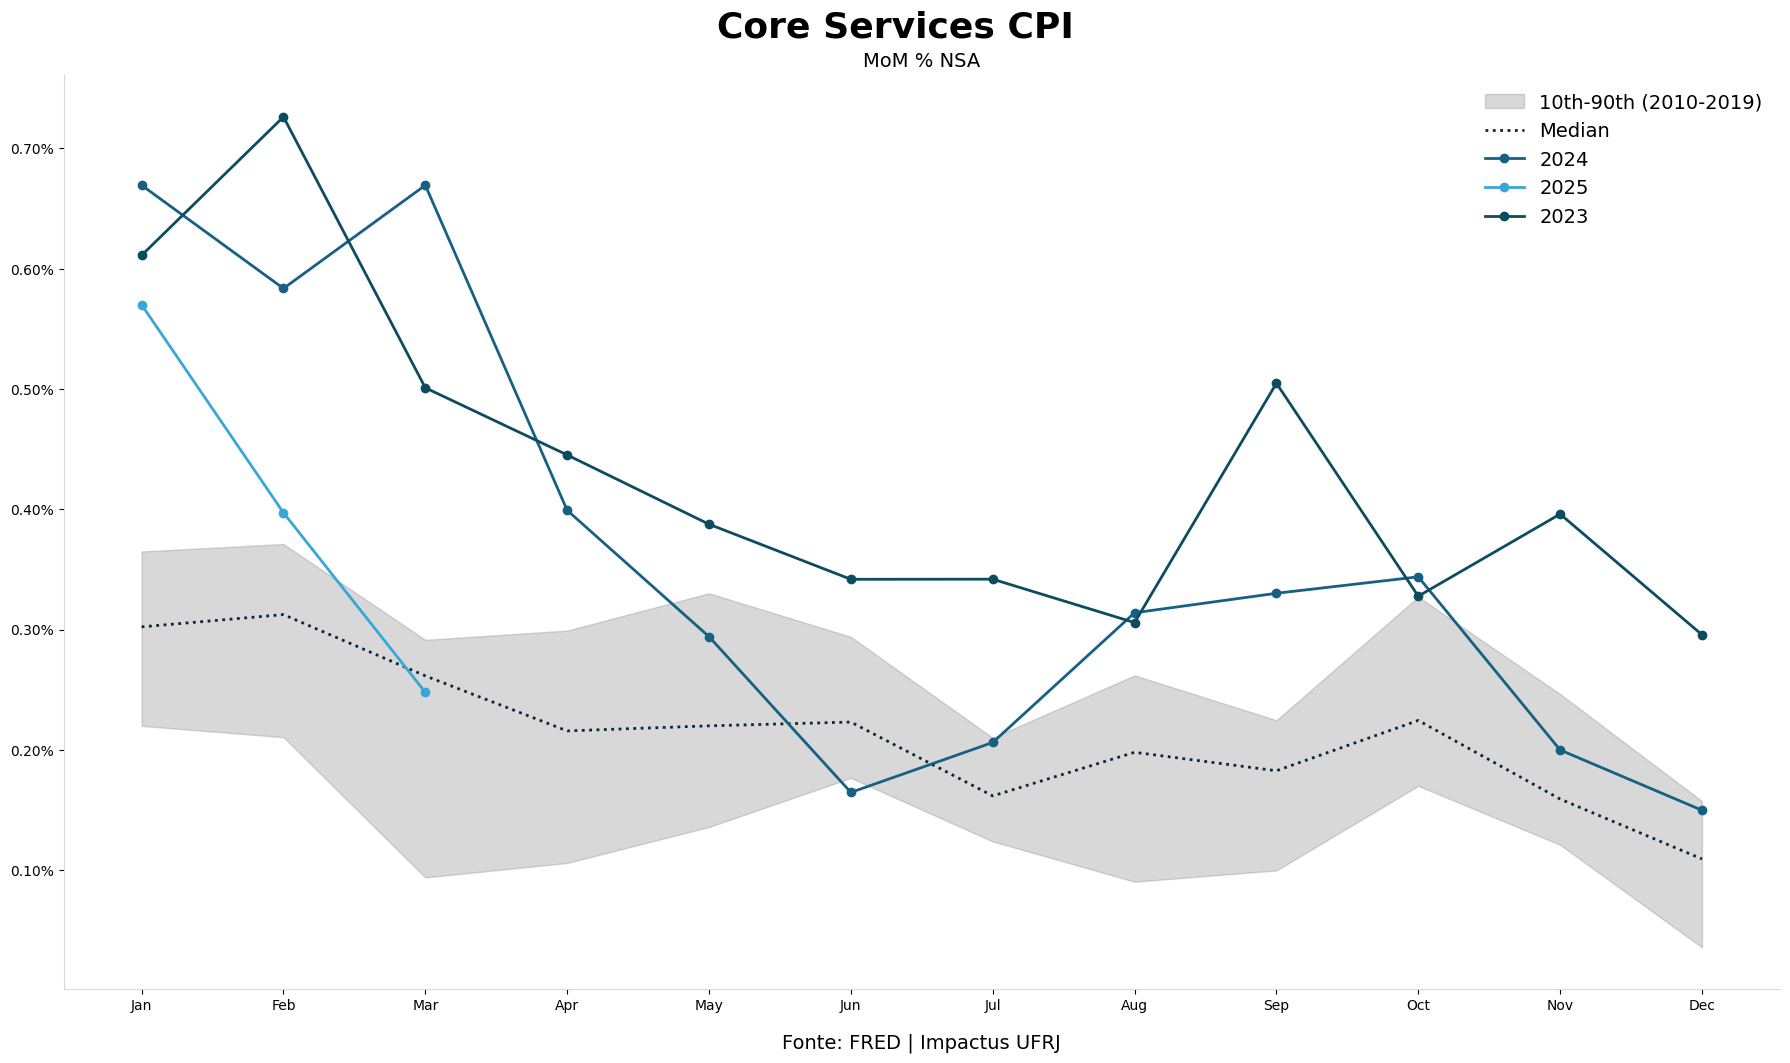

In [21]:
cpi_core_services = fred.get_series('CUUR0000SASLE')
cpi_core_services_us = pd.DataFrame()
cpi_core_services_us["MoM %"] = pd.DataFrame(cpi_core_services).pct_change()

cpi_core_services_23 = cpi_core_services_us.loc[cpi_core_services_us.index.to_series().dt.year == 2023].copy()
cpi_core_services_24 = cpi_core_services_us.loc[cpi_core_services_us.index.to_series().dt.year == 2024].copy()
cpi_core_services_25 = cpi_core_services_us.loc[cpi_core_services_us.index.to_series().dt.year == 2025].copy()

valores_2024 = cpi_core_services_24.groupby(cpi_core_services_24.index.month)["MoM %"].first()
valores_2025 = cpi_core_services_25.groupby(cpi_core_services_25.index.month)["MoM %"].first()
valores_2023 = cpi_core_services_23.groupby(cpi_core_services_23.index.month)["MoM %"].first()

cpi_core_services_us = cpi_core_services_us[(cpi_core_services_us.index.year >= 2010) & (cpi_core_services_us.index.year <= 2019)]

percentil_10 = pd.DataFrame()
percentil_90 = pd.DataFrame()

for mes in range(1, 13):
    dados_mes = cpi_core_services_us[cpi_core_services_us.index.month == mes]["MoM %"]
    percentil_10.loc[mes, "Percentil 10"] = dados_mes.quantile(0.10)
    percentil_90.loc[mes, "Percentil 90"] = dados_mes.quantile(0.90)

valores_dos_graficos = pd.DataFrame()
valores_dos_graficos["Percentil 10"] = percentil_10["Percentil 10"]
valores_dos_graficos["Percentil 90"] = percentil_90["Percentil 90"]
valores_dos_graficos["Ano de 2024"] = valores_2024
valores_dos_graficos["Ano de 2025"] = valores_2025
valores_dos_graficos["Ano de 2023"] = valores_2023
valores_dos_graficos["Mediana"] = cpi_core_services_us.groupby(cpi_core_services_us.index.month)["MoM %"].median()
valores_dos_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.figure(figsize=(18, 10.8))

plt.fill_between(valores_dos_graficos.index, valores_dos_graficos["Percentil 10"], valores_dos_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
plt.plot(valores_dos_graficos.index, valores_dos_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
plt.suptitle("Core Services CPI", fontsize=26, fontweight='bold')
plt.title("MoM % NSA", fontsize=14)
plt.legend(frameon=False, fontsize=14, loc="upper right")

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["left"].set_color("#d9d9d9")
plt.gca().spines["bottom"].set_color("#d9d9d9")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

plt.xlabel("Fonte: FRED | Impactus UFRJ", fontsize=14, labelpad=15)
plt.tight_layout()
plt.show()

In [22]:
import requests
import pandas as pd
from datetime import datetime

# BLS API endpoint
BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"

# Opcional: API Key (recomendado se fizer várias requisições)
API_KEY = '05fb5a8c0bb54ebcb518fbeb8183e758'  # Ou 'SUA_API_KEY_AQUI'

# Série CPI
series_id = "CUUR0000SA0L12E4"

# Define os anos de início e fim
start_year = 1947  
end_year = datetime.now().year  

# A API permite apenas um intervalo máximo de 20 anos por requisição
MAX_YEARS = 20  

# Lista para armazenar os dados
all_data = []

# Loop para dividir os anos em blocos de 20 anos
for start in range(start_year, end_year + 1, MAX_YEARS):
    stop = min(start + MAX_YEARS - 1, end_year)

    print(f"Buscando dados de {start} a {stop}...")

    payload = {
        "seriesid": [series_id],
        "startyear": str(start),
        "endyear": str(stop)
    }

    if API_KEY:
        payload["registrationKey"] = API_KEY

    response = requests.post(BLS_API_URL, json=payload)

    if response.status_code == 200:
        data = response.json()
        
        if 'Results' in data and 'series' in data['Results']:
            series_data = data['Results']['series'][0].get('data', [])
            all_data.extend(series_data)  # Adiciona os dados à lista geral
        else:
            print(f"Nenhum dado encontrado para {start}-{stop}.")
    else:
        print(f"Erro na requisição {start}-{stop}: {response.status_code} - {response.text}")

# Verifica se obteve dados
if all_data:
    df = pd.DataFrame(all_data)

    # Verifica se as colunas necessárias existem antes de acessá-las
    required_columns = {'year', 'value', 'period', 'periodName'}
    missing_columns = required_columns - set(df.columns)
    
    if missing_columns:
        print(f"Erro: As colunas esperadas estão ausentes: {missing_columns}")
    else:
        # Processa o DataFrame
        df['year'] = df['year'].astype(int)
        df['value'] = df['value'].astype(float)
        
        # Converte a data corretamente
        df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['period'].str[1:] + '-01')

        # Ordena pela data crescente
        df = df.sort_values('date').reset_index(drop=True)

        # Exibe o DataFrame final
        print(df.head())  # Ou df.tail(), para ver os últimos registros
else:
    print("Nenhum dado disponível para a série informada.")


Buscando dados de 1947 a 1966...
Buscando dados de 1967 a 1986...
Buscando dados de 1987 a 2006...
Buscando dados de 2007 a 2025...
   year period periodName  value footnotes latest       date
0  1967    M01    January   38.9      [{}]    NaN 1967-01-01
1  1967    M02   February   39.0      [{}]    NaN 1967-02-01
2  1967    M03      March   39.1      [{}]    NaN 1967-03-01
3  1967    M04      April   39.3      [{}]    NaN 1967-04-01
4  1967    M05        May   39.3      [{}]    NaN 1967-05-01


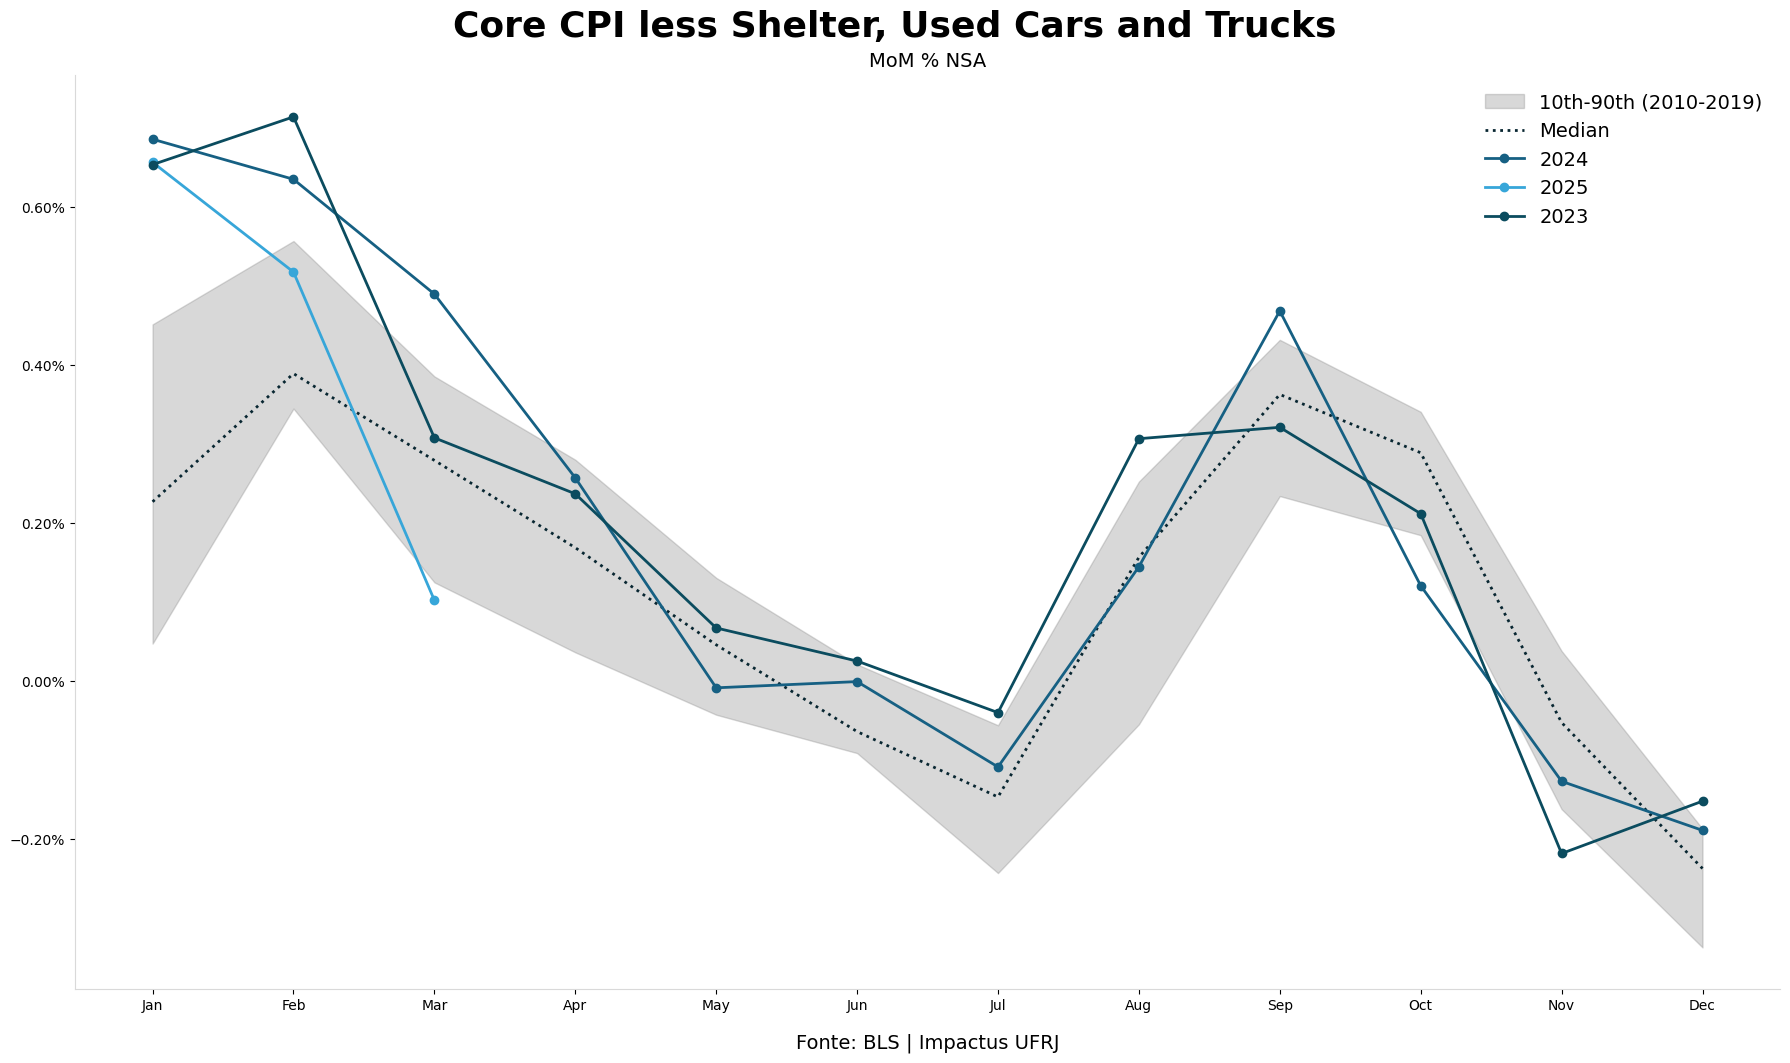

In [23]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime

BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
API_KEY = "05fb5a8c0bb54ebcb518fbeb8183e758"
series_id = "CUUR0000SA0L12E4"

start_year = 1947
end_year = datetime.now().year
MAX_YEARS = 20

all_items_data = []

for start in range(start_year, end_year + 1, MAX_YEARS):
    stop = min(start + MAX_YEARS - 1, end_year)
    payload = {"seriesid": [series_id], "startyear": str(start), "endyear": str(stop)}
    if API_KEY:
        payload["registrationKey"] = API_KEY
    response = requests.post(BLS_API_URL, json=payload)
    if response.status_code == 200:
        data = response.json()
        if 'Results' in data and 'series' in data['Results']:
            all_items_data.extend(data['Results']['series'][0].get('data', []))

if all_items_data:
    df = pd.DataFrame(all_items_data)
    df['year'] = df['year'].astype(int)
    df['value'] = df['value'].astype(float)
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['period'].str[1:] + '-01')
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    
    df_cpi_filtered = pd.DataFrame()
    df_cpi_filtered["MoM %"] = df["value"].pct_change()
    
    df_cpi_23 = df_cpi_filtered[df_cpi_filtered.index.year == 2023]
    df_cpi_24 = df_cpi_filtered[df_cpi_filtered.index.year == 2024]
    df_cpi_25 = df_cpi_filtered[df_cpi_filtered.index.year == 2025]
    
    valores_2024 = df_cpi_24.groupby(df_cpi_24.index.month)["MoM %"].first()
    valores_2025 = df_cpi_25.groupby(df_cpi_25.index.month)["MoM %"].first()
    valores_2023 = df_cpi_23.groupby(df_cpi_23.index.month)["MoM %"].first()
    
    df_cpi_filtered = df_cpi_filtered[(df_cpi_filtered.index.year >= 2010) & (df_cpi_filtered.index.year <= 2019)]
    percentil_10 = df_cpi_filtered.groupby(df_cpi_filtered.index.month)["MoM %"].quantile(0.10)
    percentil_90 = df_cpi_filtered.groupby(df_cpi_filtered.index.month)["MoM %"].quantile(0.90)
    mediana = df_cpi_filtered.groupby(df_cpi_filtered.index.month)["MoM %"].median()
    
    valores_graficos = pd.DataFrame({
        "Percentil 10": percentil_10,
        "Percentil 90": percentil_90,
        "Ano de 2024": valores_2024,
        "Ano de 2025": valores_2025,
        "Ano de 2023": valores_2023,
        "Mediana": mediana
    })
    valores_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    plt.figure(figsize=(18, 10.8))
    plt.fill_between(valores_graficos.index, valores_graficos["Percentil 10"], valores_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
    plt.plot(valores_graficos.index, valores_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
    
    plt.suptitle("Core CPI less Shelter, Used Cars and Trucks", fontsize=26, fontweight='bold')
    plt.title("MoM % NSA", fontsize=14)
    plt.legend(frameon=False, fontsize=14, loc="upper right")
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_color("#d9d9d9")
    plt.gca().spines["bottom"].set_color("#d9d9d9")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    plt.xlabel("Fonte: BLS | Impactus UFRJ", fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum dado disponível para a série informada.")

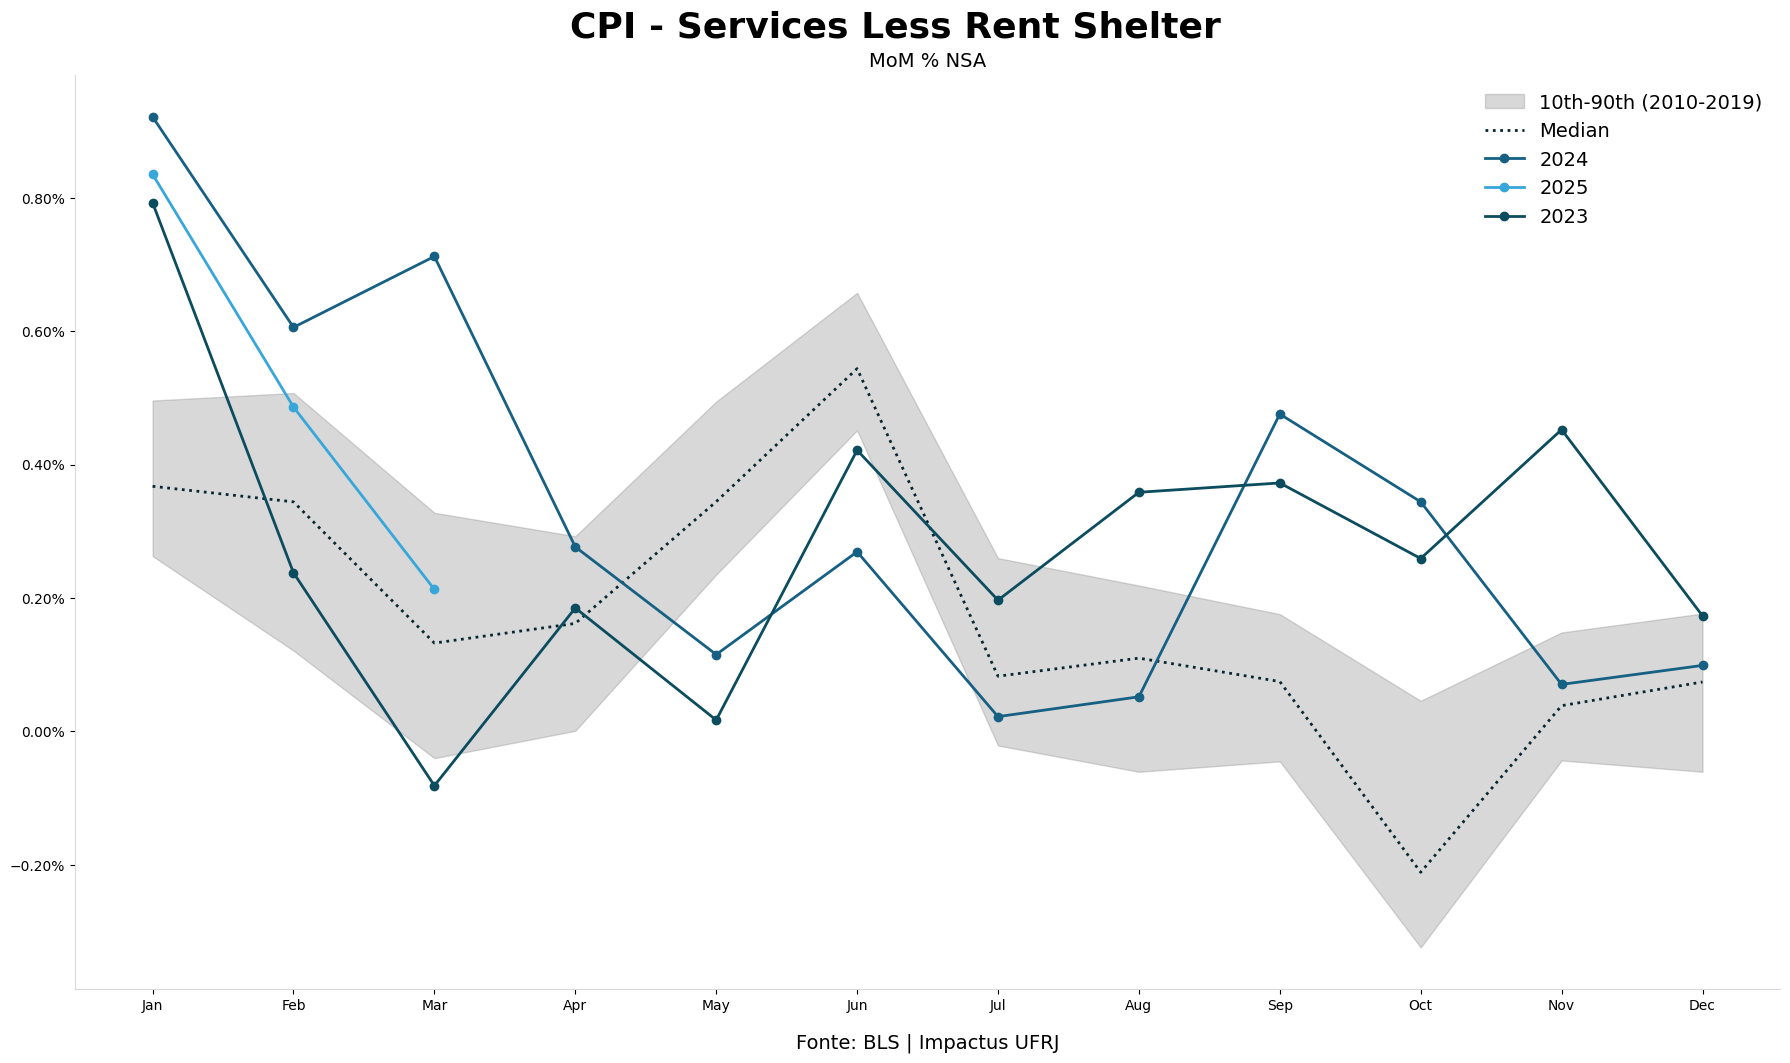

In [24]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime

BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
API_KEY = "05fb5a8c0bb54ebcb518fbeb8183e758"
series_id = "CUUR0000SASL2RS"

start_year = 1947
end_year = datetime.now().year
MAX_YEARS = 20

services_data = []

for start in range(start_year, end_year + 1, MAX_YEARS):
    stop = min(start + MAX_YEARS - 1, end_year)
    payload = {"seriesid": [series_id], "startyear": str(start), "endyear": str(stop)}
    if API_KEY:
        payload["registrationKey"] = API_KEY
    response = requests.post(BLS_API_URL, json=payload)
    if response.status_code == 200:
        data = response.json()
        if 'Results' in data and 'series' in data['Results']:
            services_data.extend(data['Results']['series'][0].get('data', []))

if services_data:
    df = pd.DataFrame(services_data)
    df['year'] = df['year'].astype(int)
    df['value'] = df['value'].astype(float)
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['period'].str[1:] + '-01')
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    
    df_cpi_services = pd.DataFrame()
    df_cpi_services["MoM %"] = df["value"].pct_change()
    
    df_cpi_23 = df_cpi_services[df_cpi_services.index.year == 2023]
    df_cpi_24 = df_cpi_services[df_cpi_services.index.year == 2024]
    df_cpi_25 = df_cpi_services[df_cpi_services.index.year == 2025]
    
    valores_2024 = df_cpi_24.groupby(df_cpi_24.index.month)["MoM %"].first()
    valores_2025 = df_cpi_25.groupby(df_cpi_25.index.month)["MoM %"].first()
    valores_2023 = df_cpi_23.groupby(df_cpi_23.index.month)["MoM %"].first()
    
    df_cpi_services = df_cpi_services[(df_cpi_services.index.year >= 2010) & (df_cpi_services.index.year <= 2019)]
    percentil_10 = df_cpi_services.groupby(df_cpi_services.index.month)["MoM %"].quantile(0.10)
    percentil_90 = df_cpi_services.groupby(df_cpi_services.index.month)["MoM %"].quantile(0.90)
    mediana = df_cpi_services.groupby(df_cpi_services.index.month)["MoM %"].median()
    
    valores_graficos = pd.DataFrame({
        "Percentil 10": percentil_10,
        "Percentil 90": percentil_90,
        "Ano de 2024": valores_2024,
        "Ano de 2025": valores_2025,
        "Ano de 2023": valores_2023,
        "Mediana": mediana
    })
    
    valores_graficos = valores_graficos.reindex(range(1, 13))
    valores_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    plt.figure(figsize=(18, 10.8))
    plt.fill_between(valores_graficos.index, valores_graficos["Percentil 10"], valores_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
    plt.plot(valores_graficos.index, valores_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
    
    plt.suptitle("CPI - Services Less Rent Shelter", fontsize=26, fontweight='bold')
    plt.title("MoM % NSA", fontsize=14)
    plt.legend(frameon=False, fontsize=14, loc="upper right")
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_color("#d9d9d9")
    plt.gca().spines["bottom"].set_color("#d9d9d9")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    plt.xlabel("Fonte: BLS | Impactus UFRJ", fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum dado disponível para a série informada.")


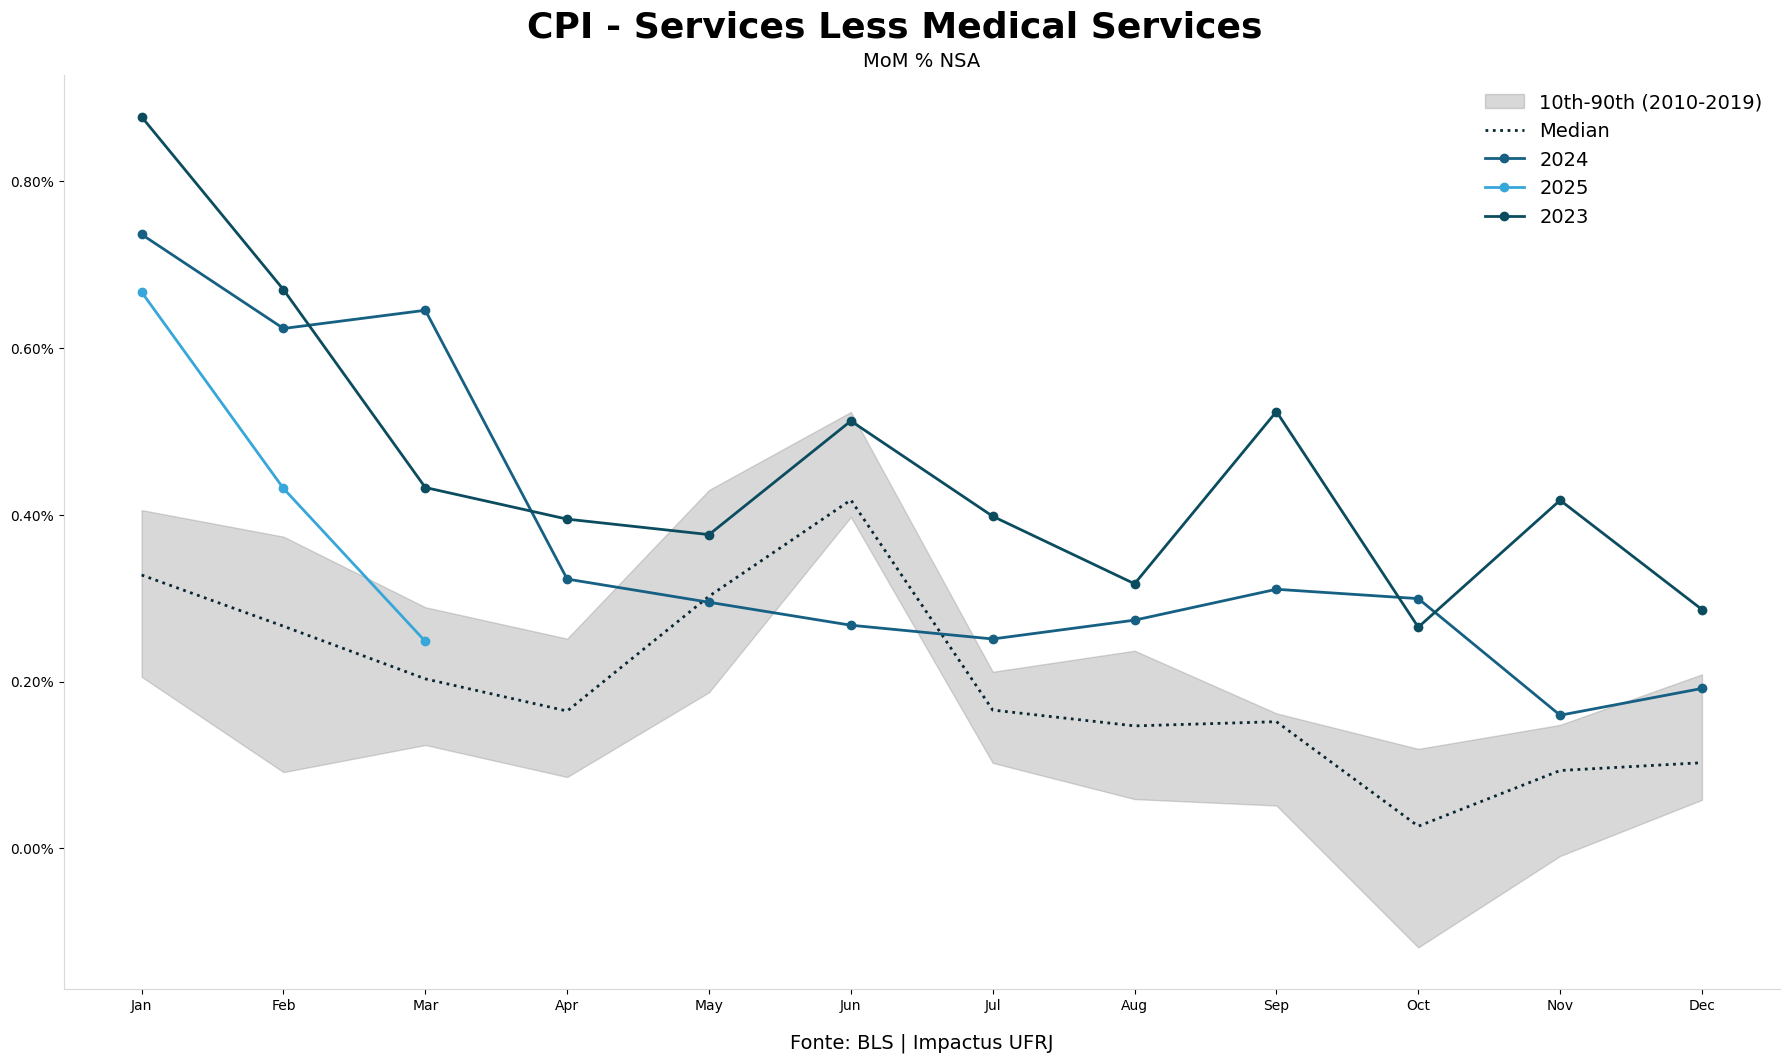

In [25]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import datetime

BLS_API_URL = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
API_KEY = "05fb5a8c0bb54ebcb518fbeb8183e758"
series_id = "CUUR0000SASL5"

start_year = 1947
end_year = datetime.now().year
MAX_YEARS = 20

services_data = []

for start in range(start_year, end_year + 1, MAX_YEARS):
    stop = min(start + MAX_YEARS - 1, end_year)
    payload = {"seriesid": [series_id], "startyear": str(start), "endyear": str(stop)}
    if API_KEY:
        payload["registrationKey"] = API_KEY
    response = requests.post(BLS_API_URL, json=payload)
    if response.status_code == 200:
        data = response.json()
        if 'Results' in data and 'series' in data['Results']:
            services_data.extend(data['Results']['series'][0].get('data', []))

if services_data:
    df = pd.DataFrame(services_data)
    df['year'] = df['year'].astype(int)
    df['value'] = df['value'].astype(float)
    df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['period'].str[1:] + '-01')
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    
    df_cpi_services = pd.DataFrame()
    df_cpi_services["MoM %"] = df["value"].pct_change()
    
    df_cpi_23 = df_cpi_services[df_cpi_services.index.year == 2023]
    df_cpi_24 = df_cpi_services[df_cpi_services.index.year == 2024]
    df_cpi_25 = df_cpi_services[df_cpi_services.index.year == 2025]
    
    valores_2024 = df_cpi_24.groupby(df_cpi_24.index.month)["MoM %"].first()
    valores_2025 = df_cpi_25.groupby(df_cpi_25.index.month)["MoM %"].first()
    valores_2023 = df_cpi_23.groupby(df_cpi_23.index.month)["MoM %"].first()
    
    df_cpi_services = df_cpi_services[(df_cpi_services.index.year >= 2010) & (df_cpi_services.index.year <= 2019)]
    percentil_10 = df_cpi_services.groupby(df_cpi_services.index.month)["MoM %"].quantile(0.10)
    percentil_90 = df_cpi_services.groupby(df_cpi_services.index.month)["MoM %"].quantile(0.90)
    mediana = df_cpi_services.groupby(df_cpi_services.index.month)["MoM %"].median()
    
    valores_graficos = pd.DataFrame({
        "Percentil 10": percentil_10,
        "Percentil 90": percentil_90,
        "Ano de 2024": valores_2024,
        "Ano de 2025": valores_2025,
        "Ano de 2023": valores_2023,
        "Mediana": mediana
    })
    
    valores_graficos = valores_graficos.reindex(range(1, 13))
    valores_graficos.index = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    
    plt.figure(figsize=(18, 10.8))
    plt.fill_between(valores_graficos.index, valores_graficos["Percentil 10"], valores_graficos["Percentil 90"], color="grey", alpha=0.3, label="10th-90th (2010-2019)")
    plt.plot(valores_graficos.index, valores_graficos["Mediana"], linestyle="dotted", linewidth=2, color="#082631", label="Median")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2024"], marker="o", linewidth=2, color="#166083", label="2024")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2025"], marker="o", linewidth=2, color="#37A6D9", label="2025")
    plt.plot(valores_graficos.index, valores_graficos["Ano de 2023"], marker="o", linewidth=2, color="#0B4C5F", label="2023")
    
    plt.suptitle("CPI - Services Less Medical Services", fontsize=26, fontweight='bold')
    plt.title("MoM % NSA", fontsize=14)
    plt.legend(frameon=False, fontsize=14, loc="upper right")
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_color("#d9d9d9")
    plt.gca().spines["bottom"].set_color("#d9d9d9")
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    
    plt.xlabel("Fonte: BLS | Impactus UFRJ", fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum dado disponível para a série informada.")

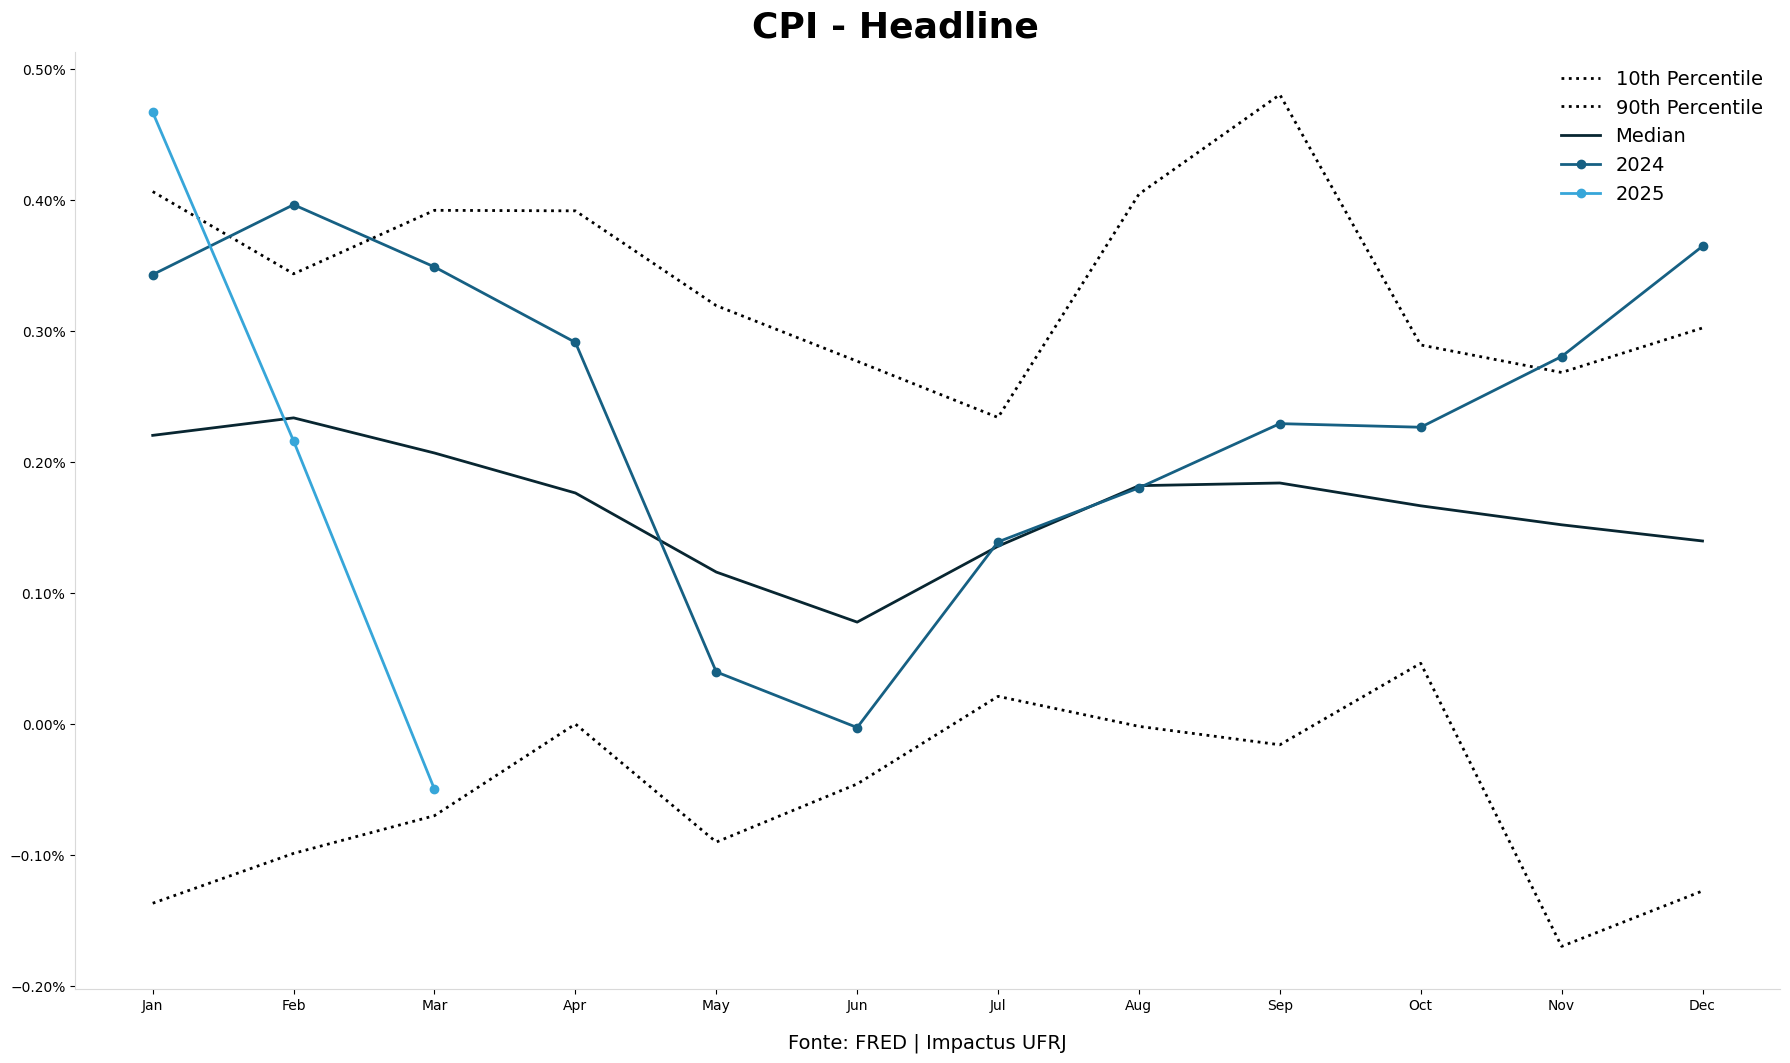

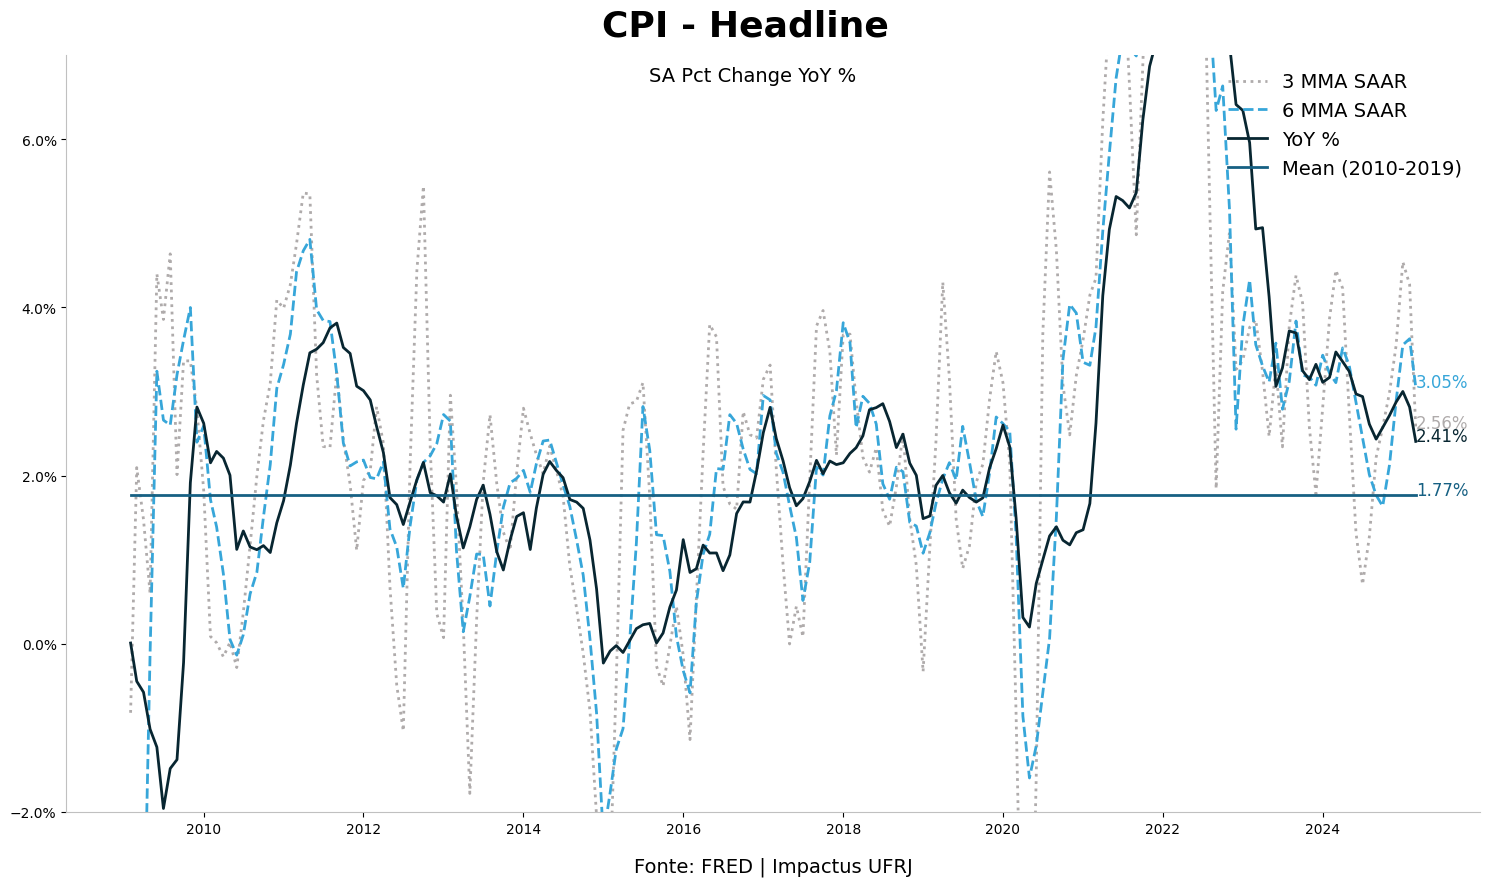

In [26]:
#cpi headline
pc = fred.get_series("CPIAUCSL")
cpi = pd.DataFrame()
cpi["Nível de preços"] = pd.DataFrame(pc)
cpi["Pct Change"] = cpi['Nível de preços'].pct_change()
cpi["Pct Change from a year ago"] = cpi['Nível de preços'].pct_change(periods=12)
graf_sa_cpi = sa_main(cpi,titulo="CPI - Headline")
graf_sa_ya = anualizar(cpi,titulo="CPI - Headline", ylim=(-0.02, 0.07))
plt.show(graf_sa_cpi)
plt.show(graf_sa_ya)

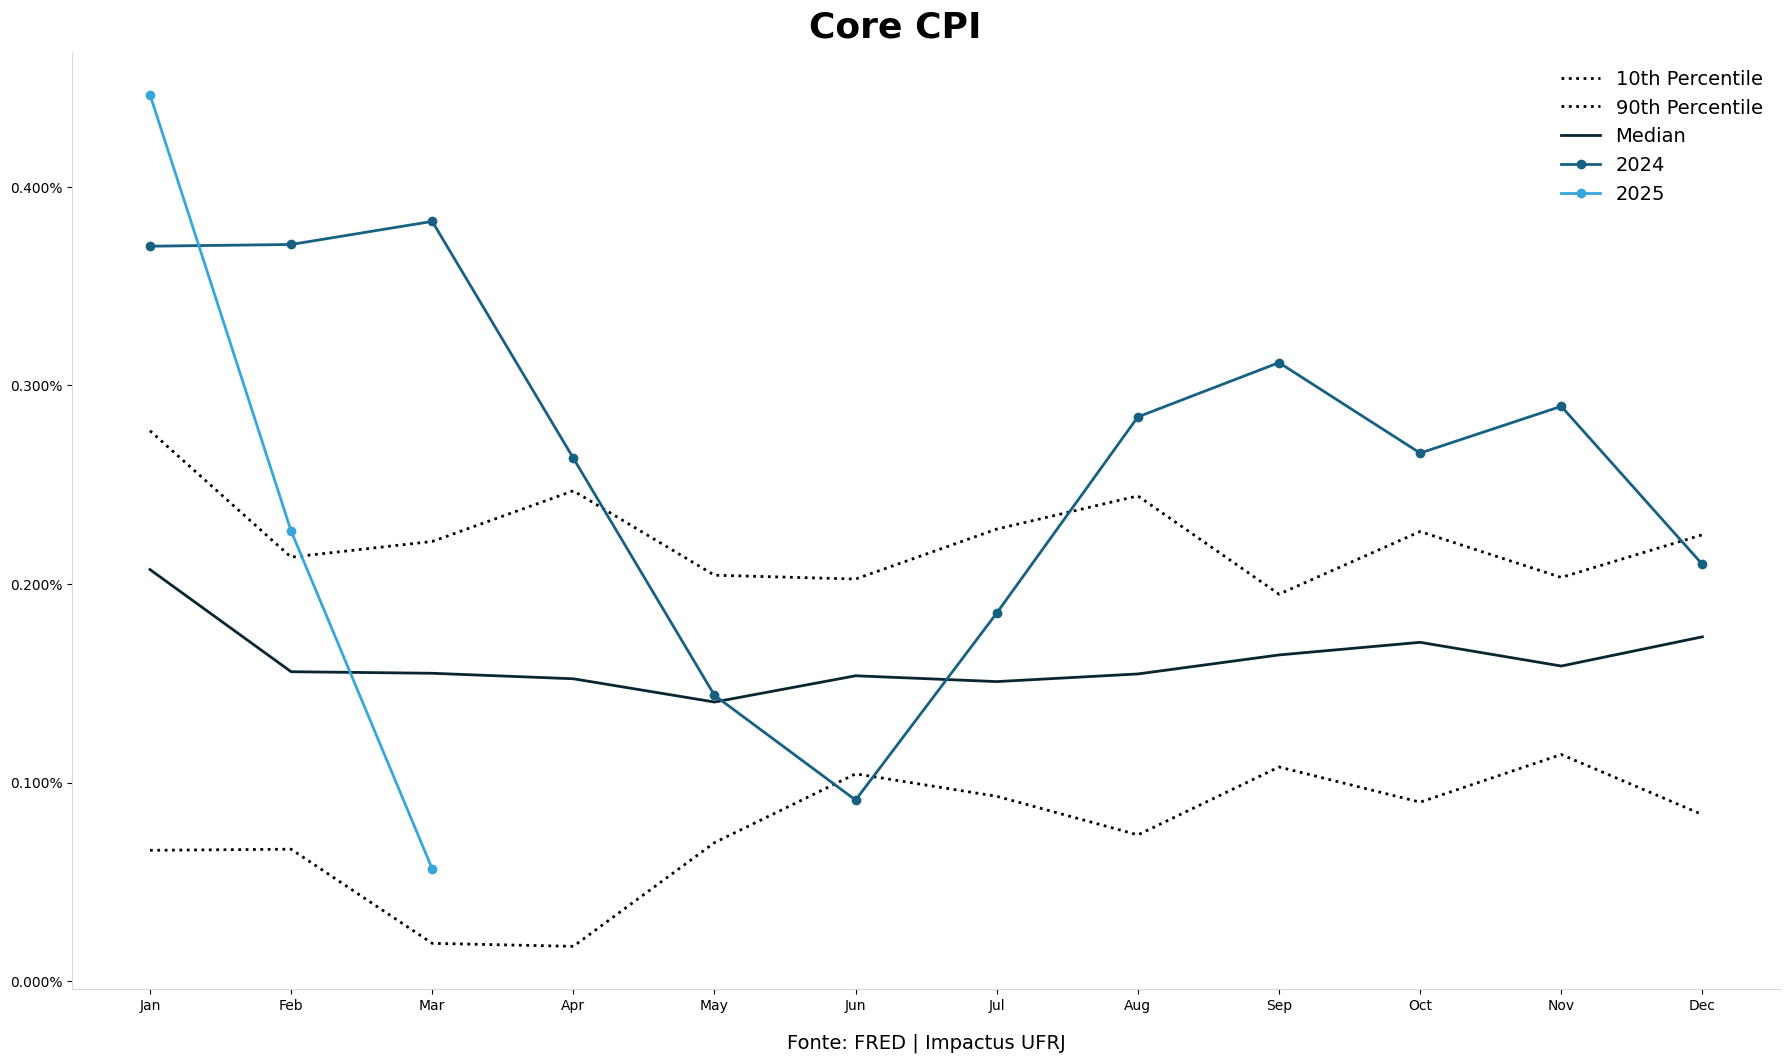

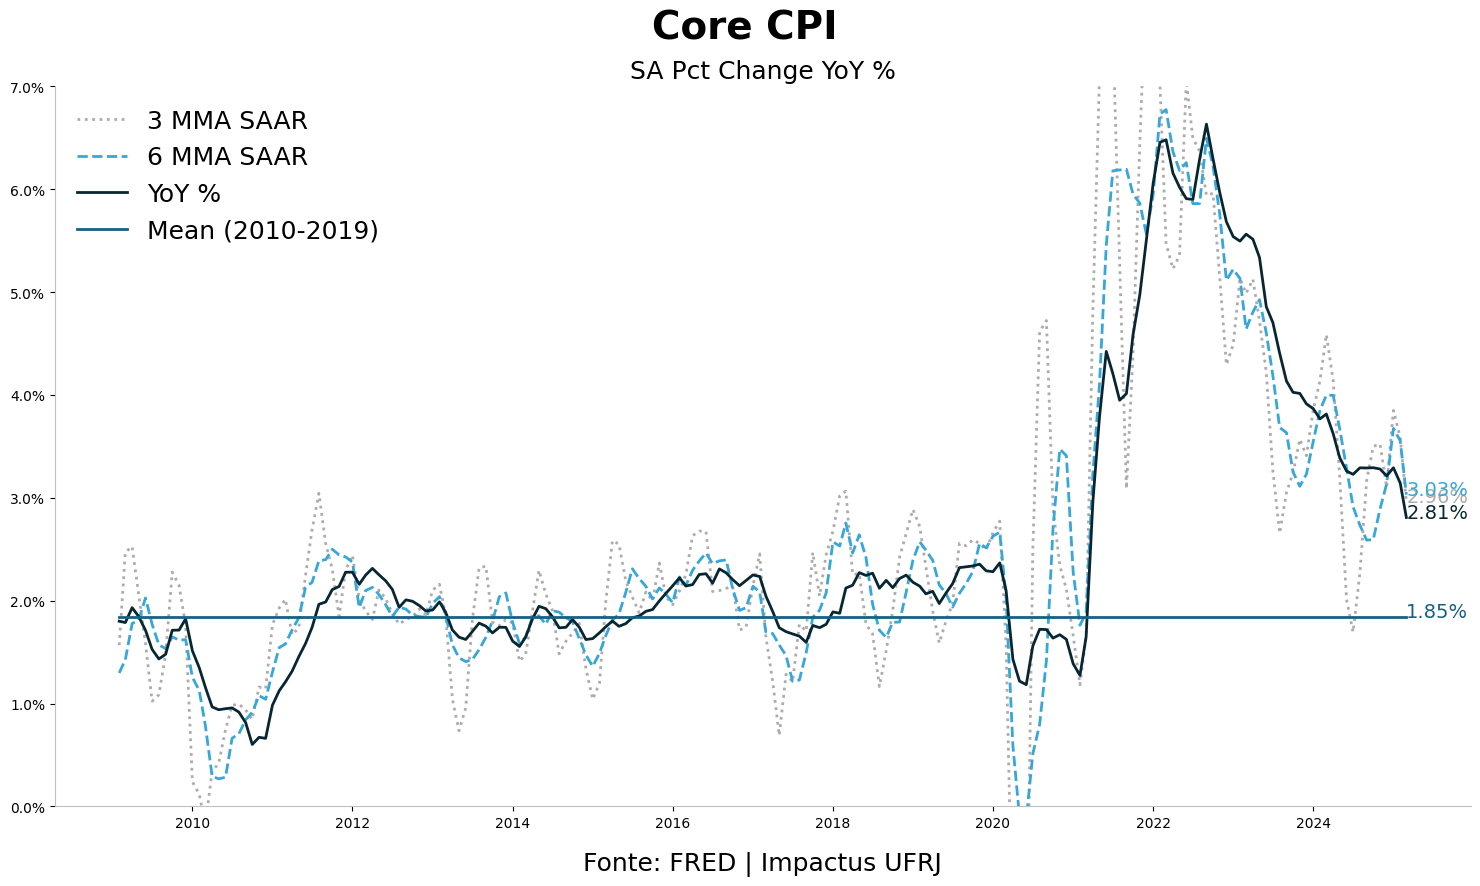

In [39]:
#cpi core
pc = fred.get_series("CPILFESL")
cpi_core = pd.DataFrame()
cpi_core["Nível de preços do núcleo"] = pd.DataFrame(pc)
cpi_core["Pct Change"] = cpi_core['Nível de preços do núcleo'].pct_change()
cpi_core["Pct Change from a year ago"] = cpi_core['Nível de preços do núcleo'].pct_change(periods=12)
graf_sa_core = sa_main(cpi_core, titulo="Core CPI")
plt.show(graf_sa_core)
graf_sa_ya = anualizar(cpi_core, titulo= "Core CPI", ylim=(0, 0.07))
plt.show(graf_sa_ya)
plt.show(graf_sa_core)

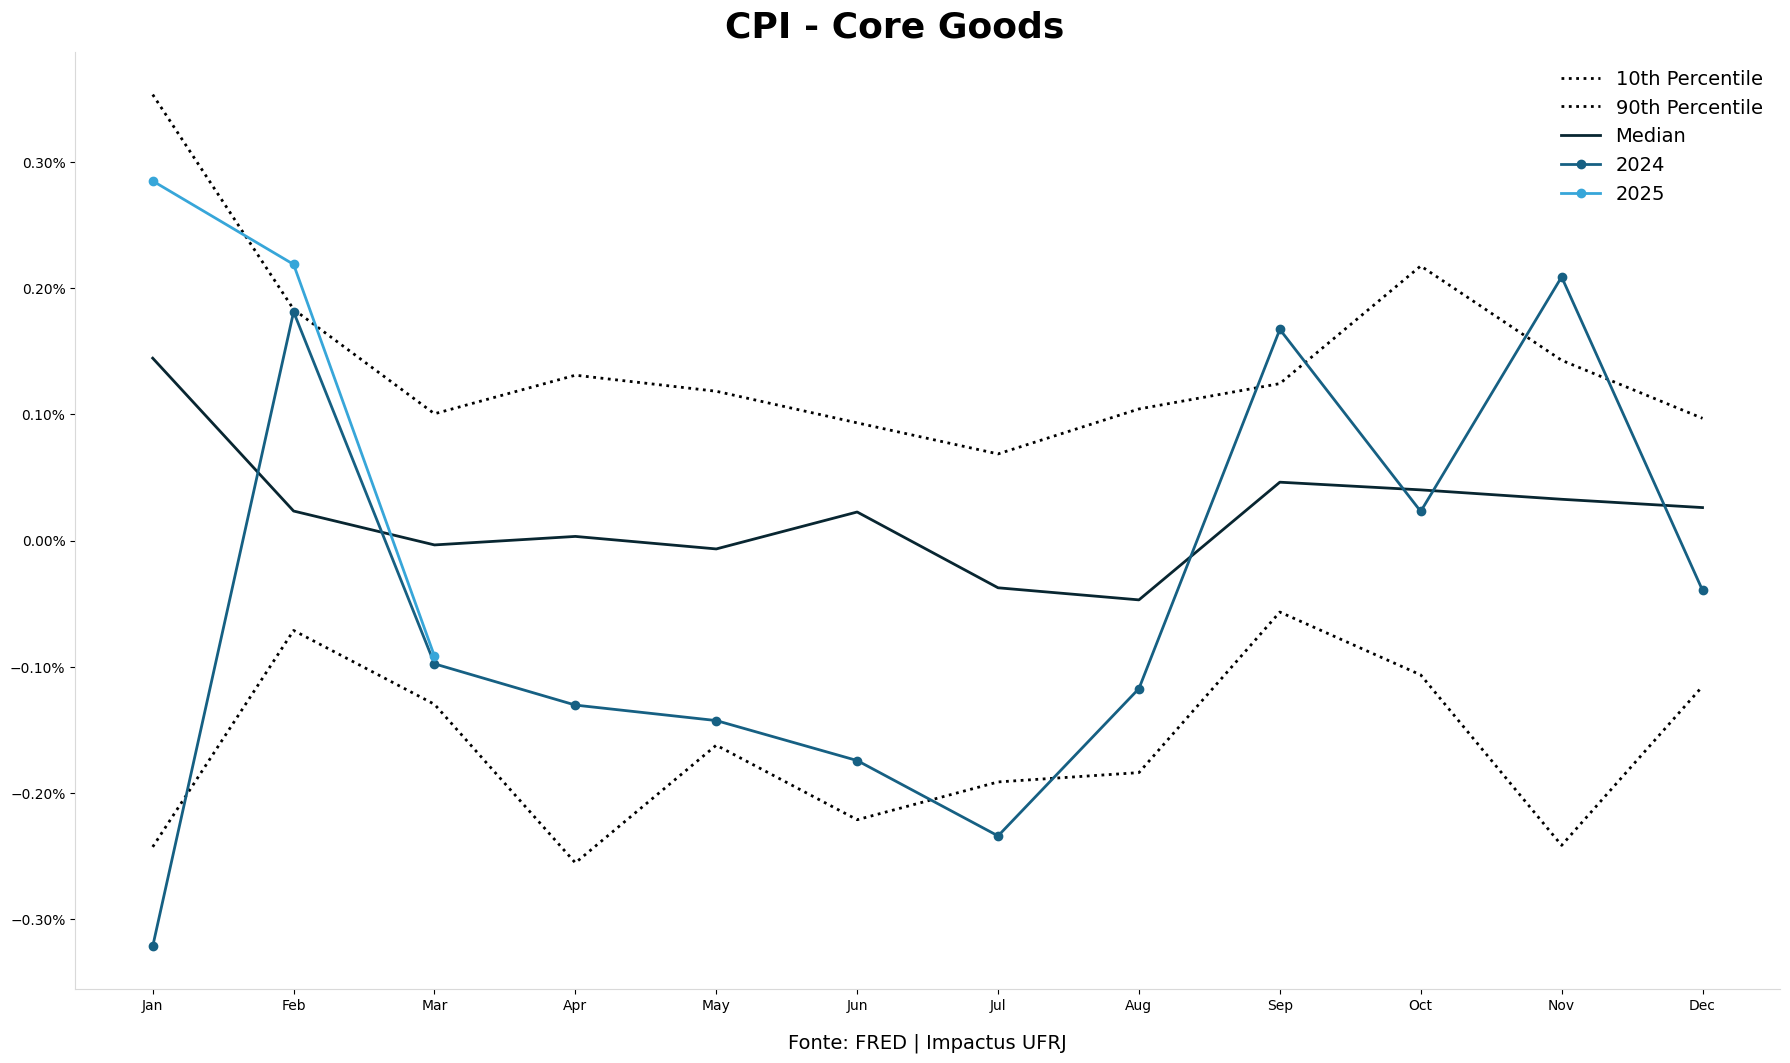

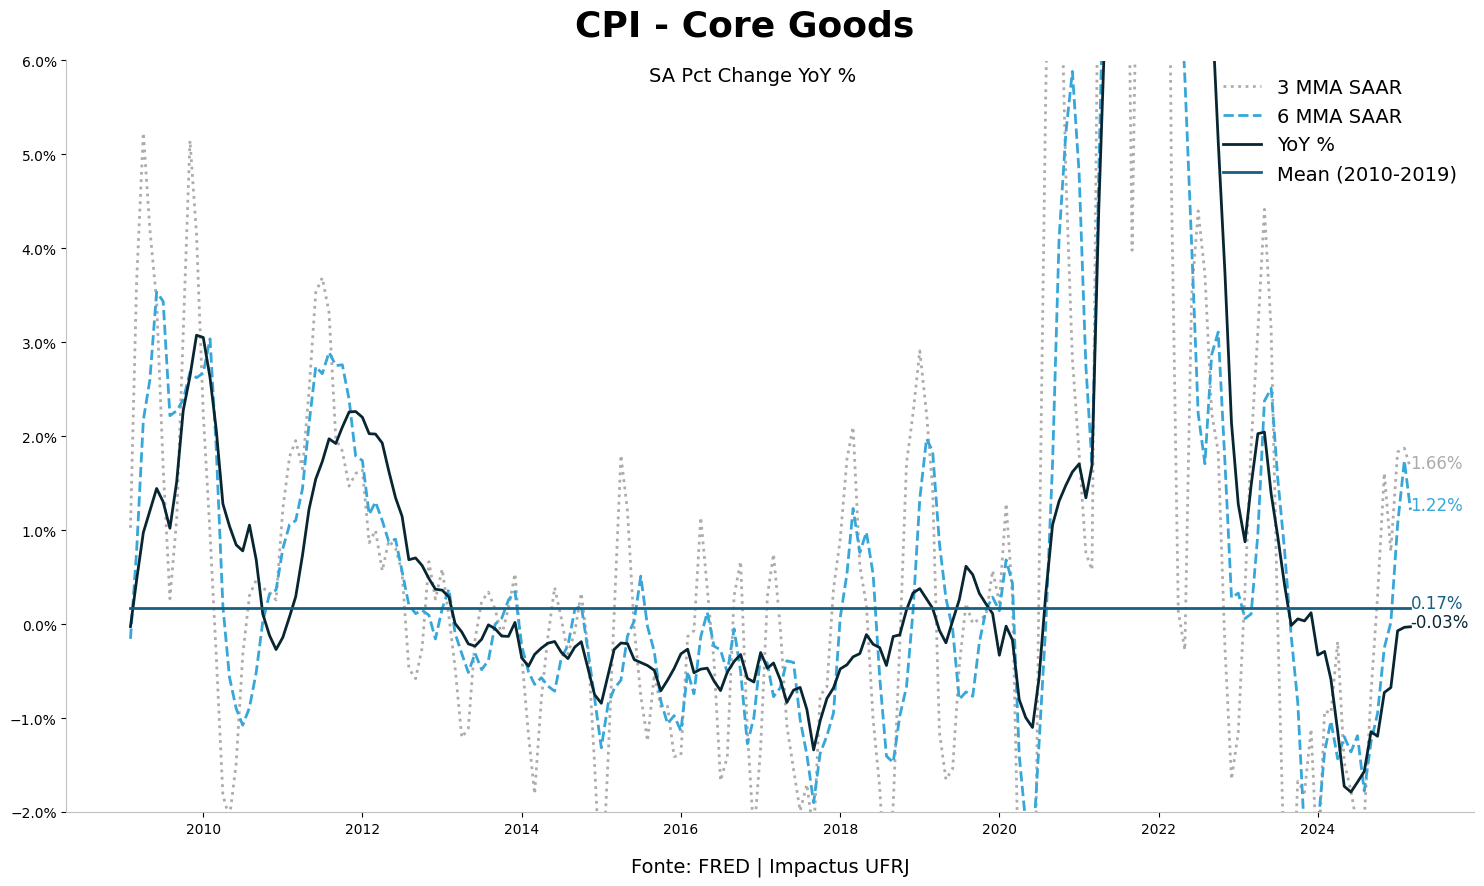

In [28]:
# core goods
pc = fred.get_series("CUSR0000SACL1E")
cpi_core_goods = pd.DataFrame()
cpi_core_goods["Nível de preços"] = pd.DataFrame(pc)
cpi_core_goods["Pct Change"] = cpi_core_goods['Nível de preços'].pct_change()
cpi_core_goods["Pct Change from a year ago"] = cpi_core_goods['Nível de preços'].pct_change(periods=12)
graf_sa_core_goods = sa_main(cpi_core_goods, titulo= "CPI - Core Goods")
graf_sa_ya = anualizar(cpi_core_goods, titulo= "CPI - Core Goods", ylim=(-0.02, 0.06))
plt.show(graf_sa_ya)
plt.show(graf_sa_core_goods)

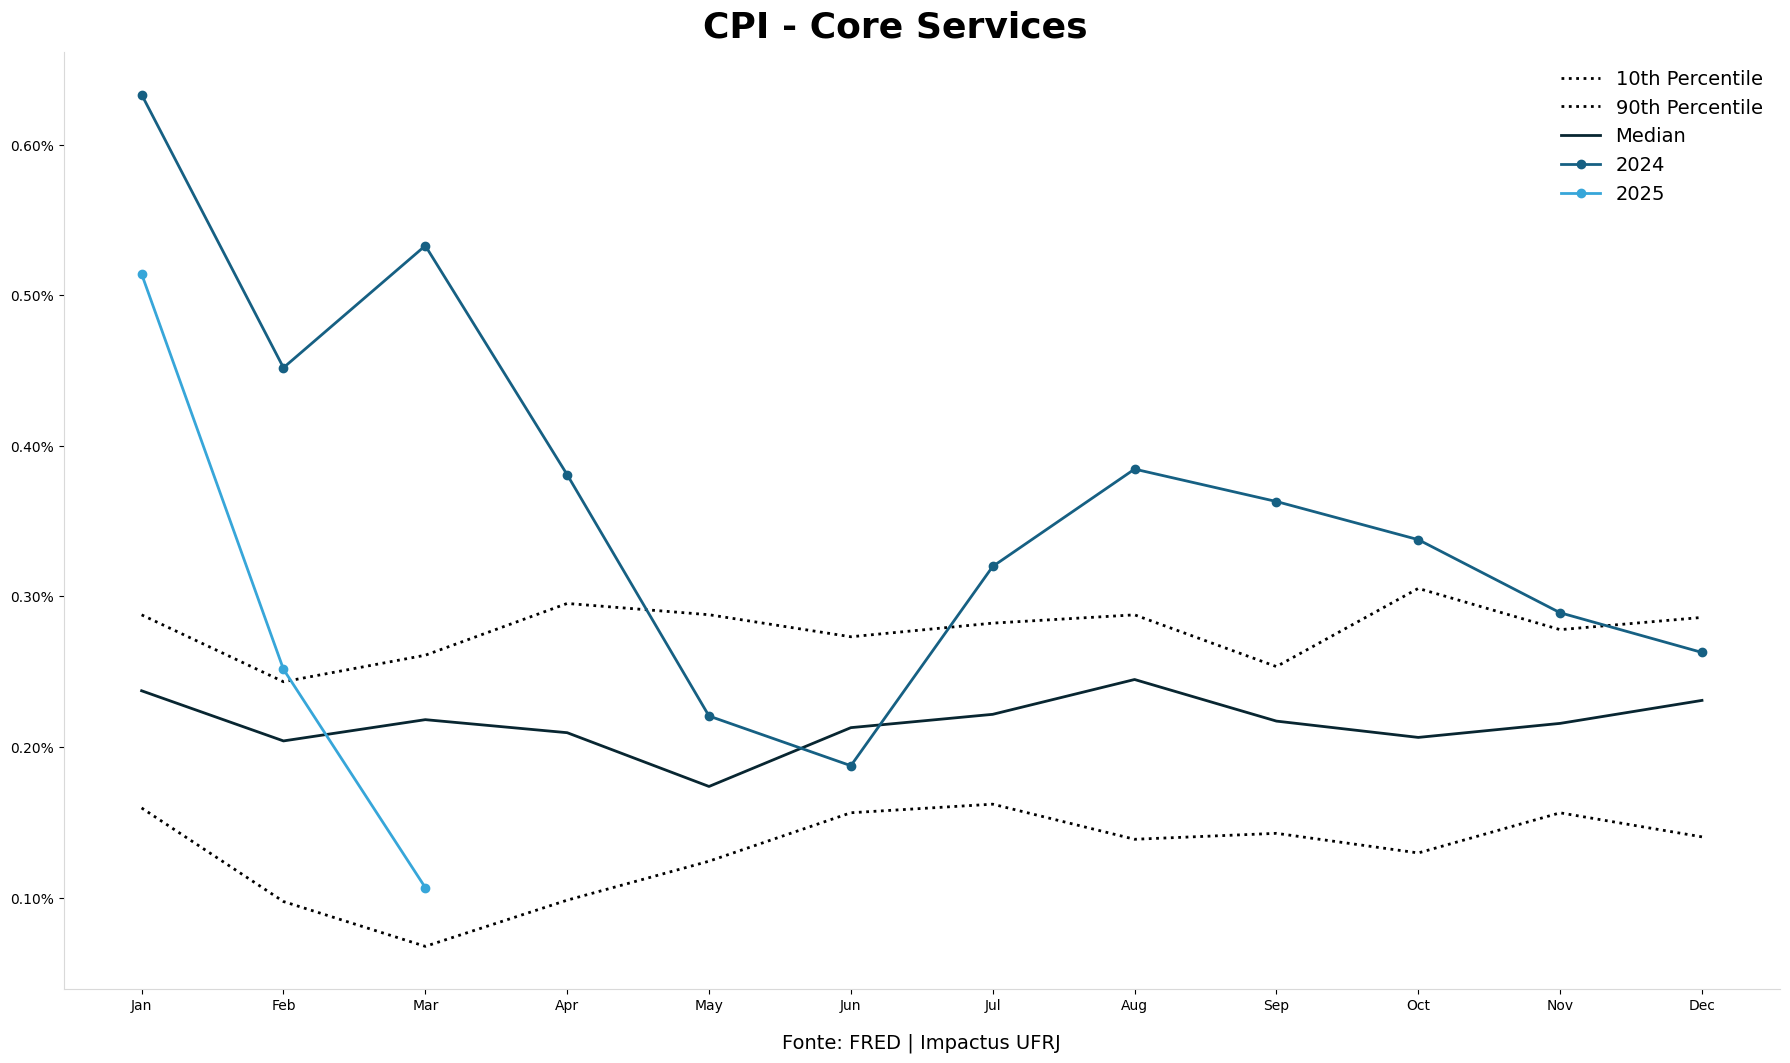

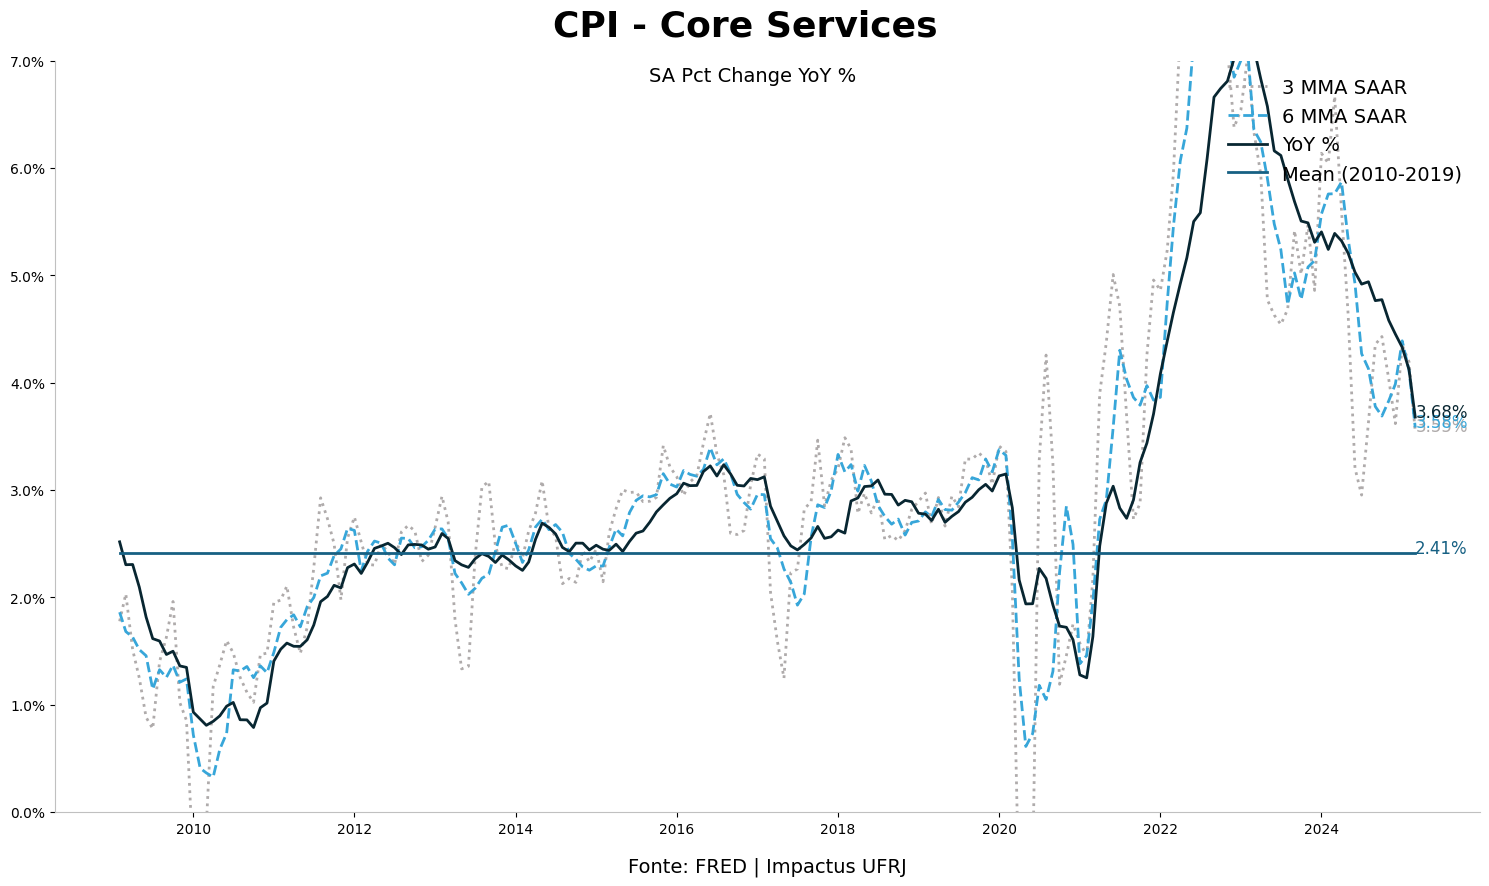

In [29]:
#core services

pc = fred.get_series("CUSR0000SASLE")
cpi_core_services = pd.DataFrame()
cpi_core_services["Nível de preços"] = pd.DataFrame(pc)
cpi_core_services["Pct Change"] = cpi_core_services['Nível de preços'].pct_change()
cpi_core_services["Pct Change from a year ago"] = cpi_core_services['Nível de preços'].pct_change(periods=12)
graf_sa_core_services = sa_main(cpi_core_services, titulo= "CPI - Core Services")
graf_sa_ya = anualizar(cpi_core_services, titulo= "CPI - Core Services", ylim=(0, 0.07))
plt.show(graf_sa_ya)
plt.show(graf_sa_core_services)

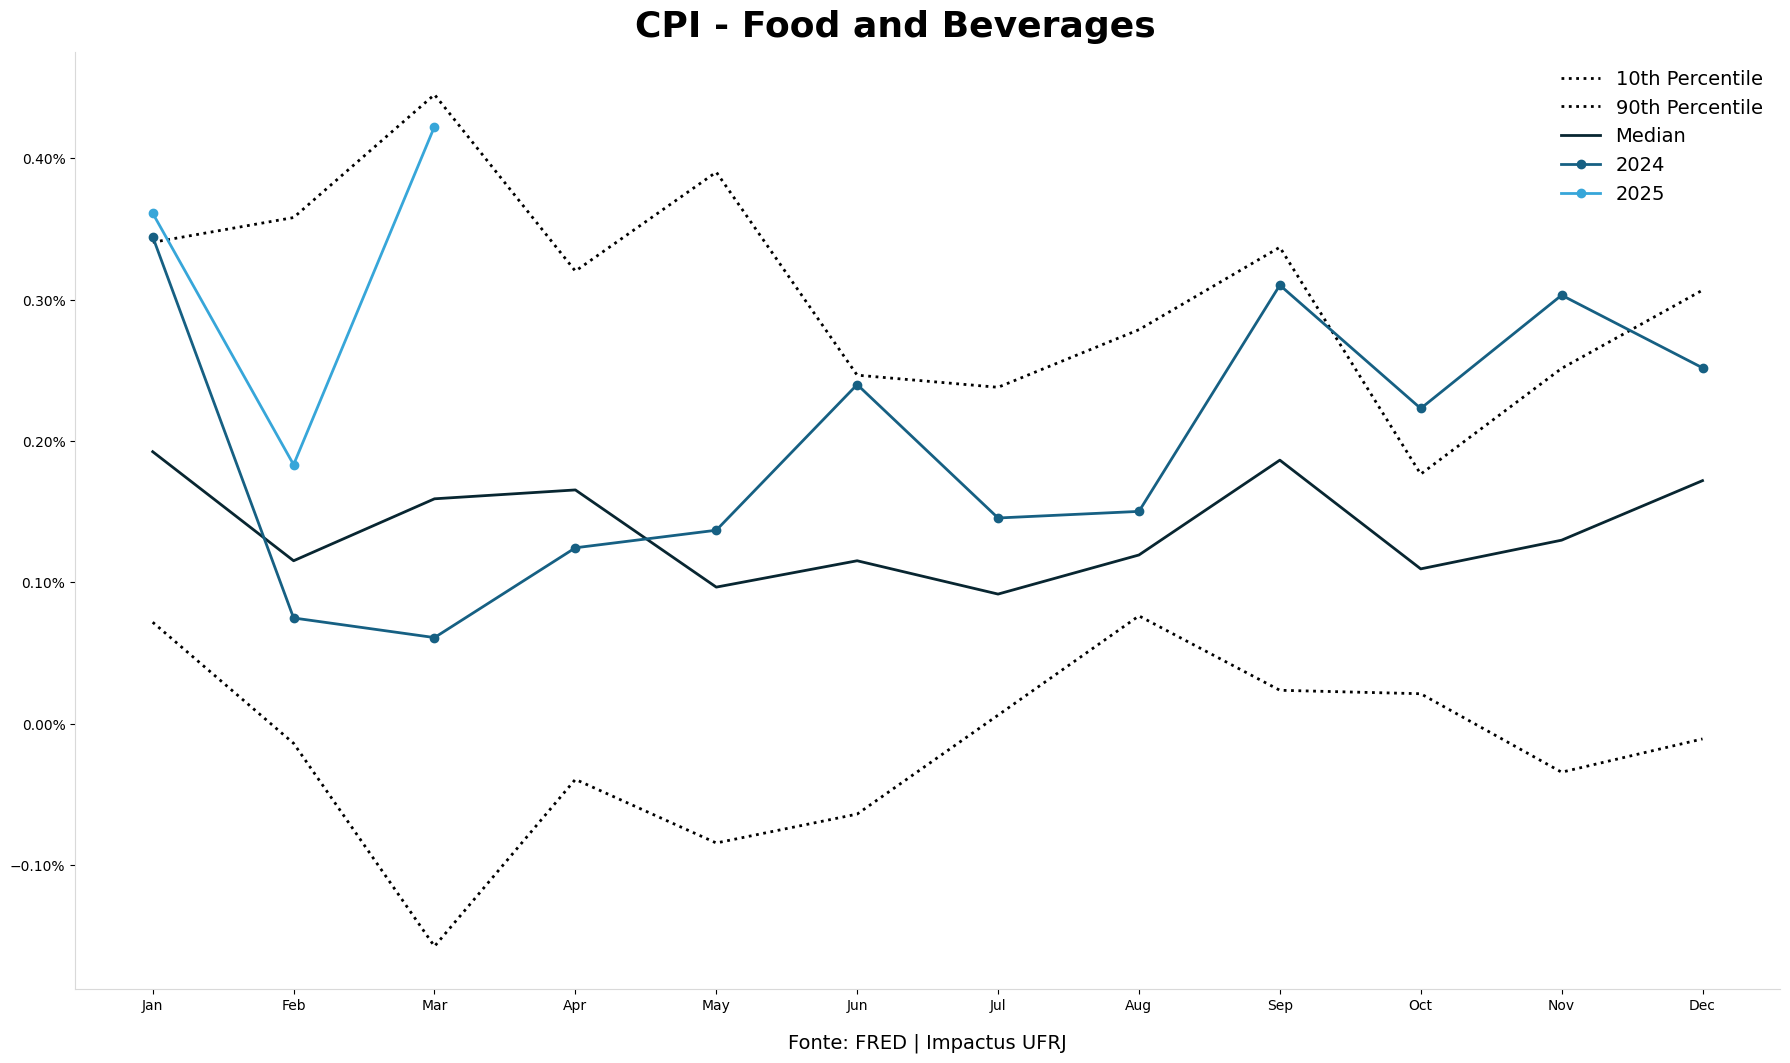

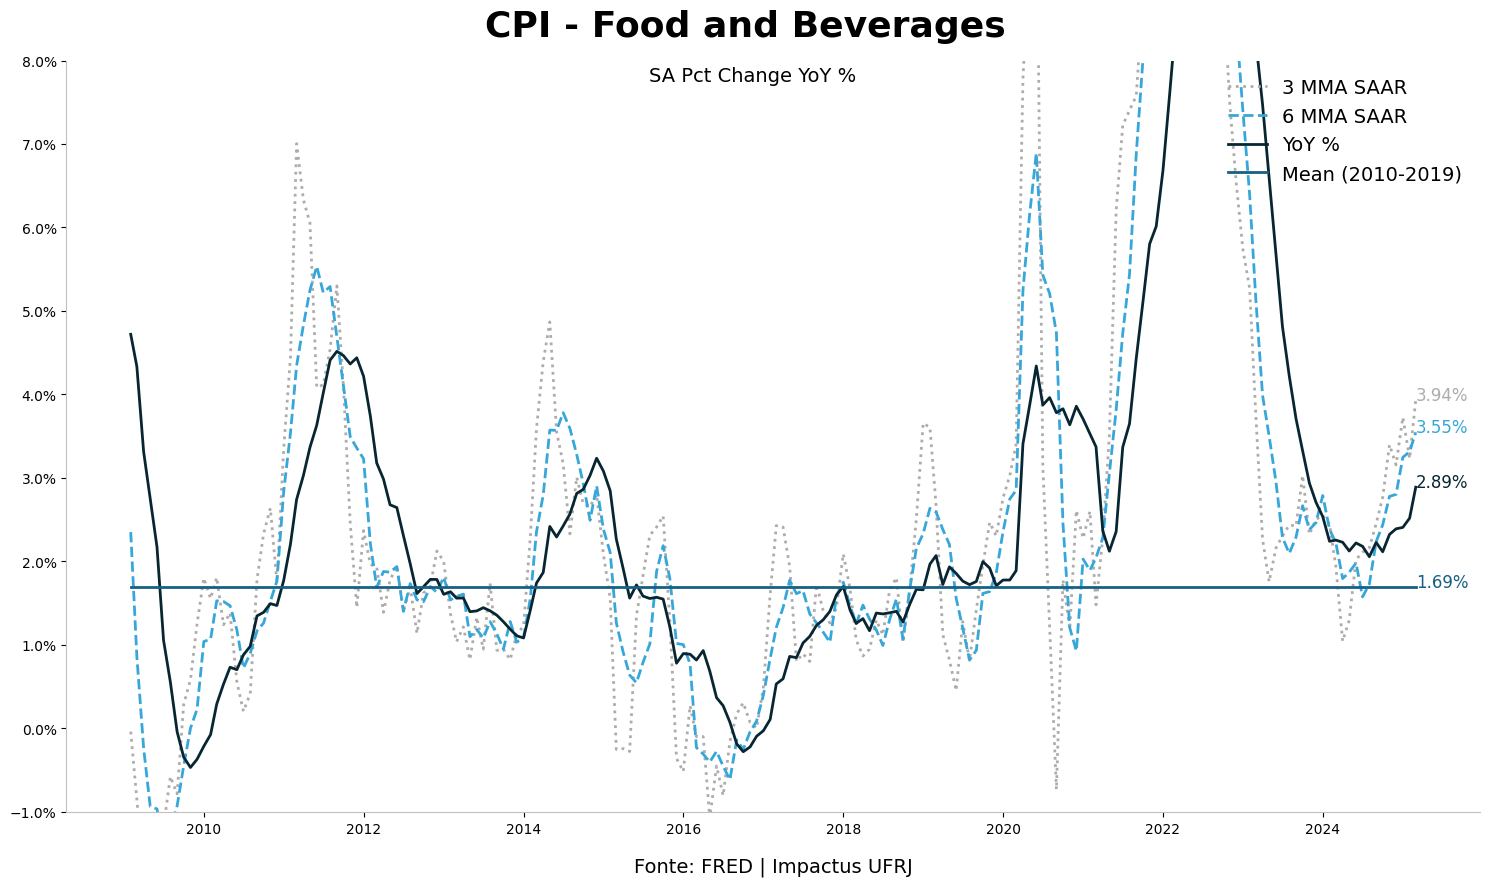

In [30]:
#food and beverages

pc = fred.get_series("CPIFABSL")
cpi_food = pd.DataFrame()
cpi_food["Nível de preços"] = pd.DataFrame(pc)
cpi_food["Pct Change"] = cpi_food['Nível de preços'].pct_change()
cpi_food["Pct Change from a year ago"] = cpi_food['Nível de preços'].pct_change(periods=12)

graf_sa_food = sa_main(cpi_food, titulo= "CPI - Food and Beverages")
graf_sa_ya = anualizar(cpi_food, titulo= "CPI - Food and Beverages", ylim=(-0.01, 0.08))
plt.show(graf_sa_ya)
plt.show(graf_sa_food)

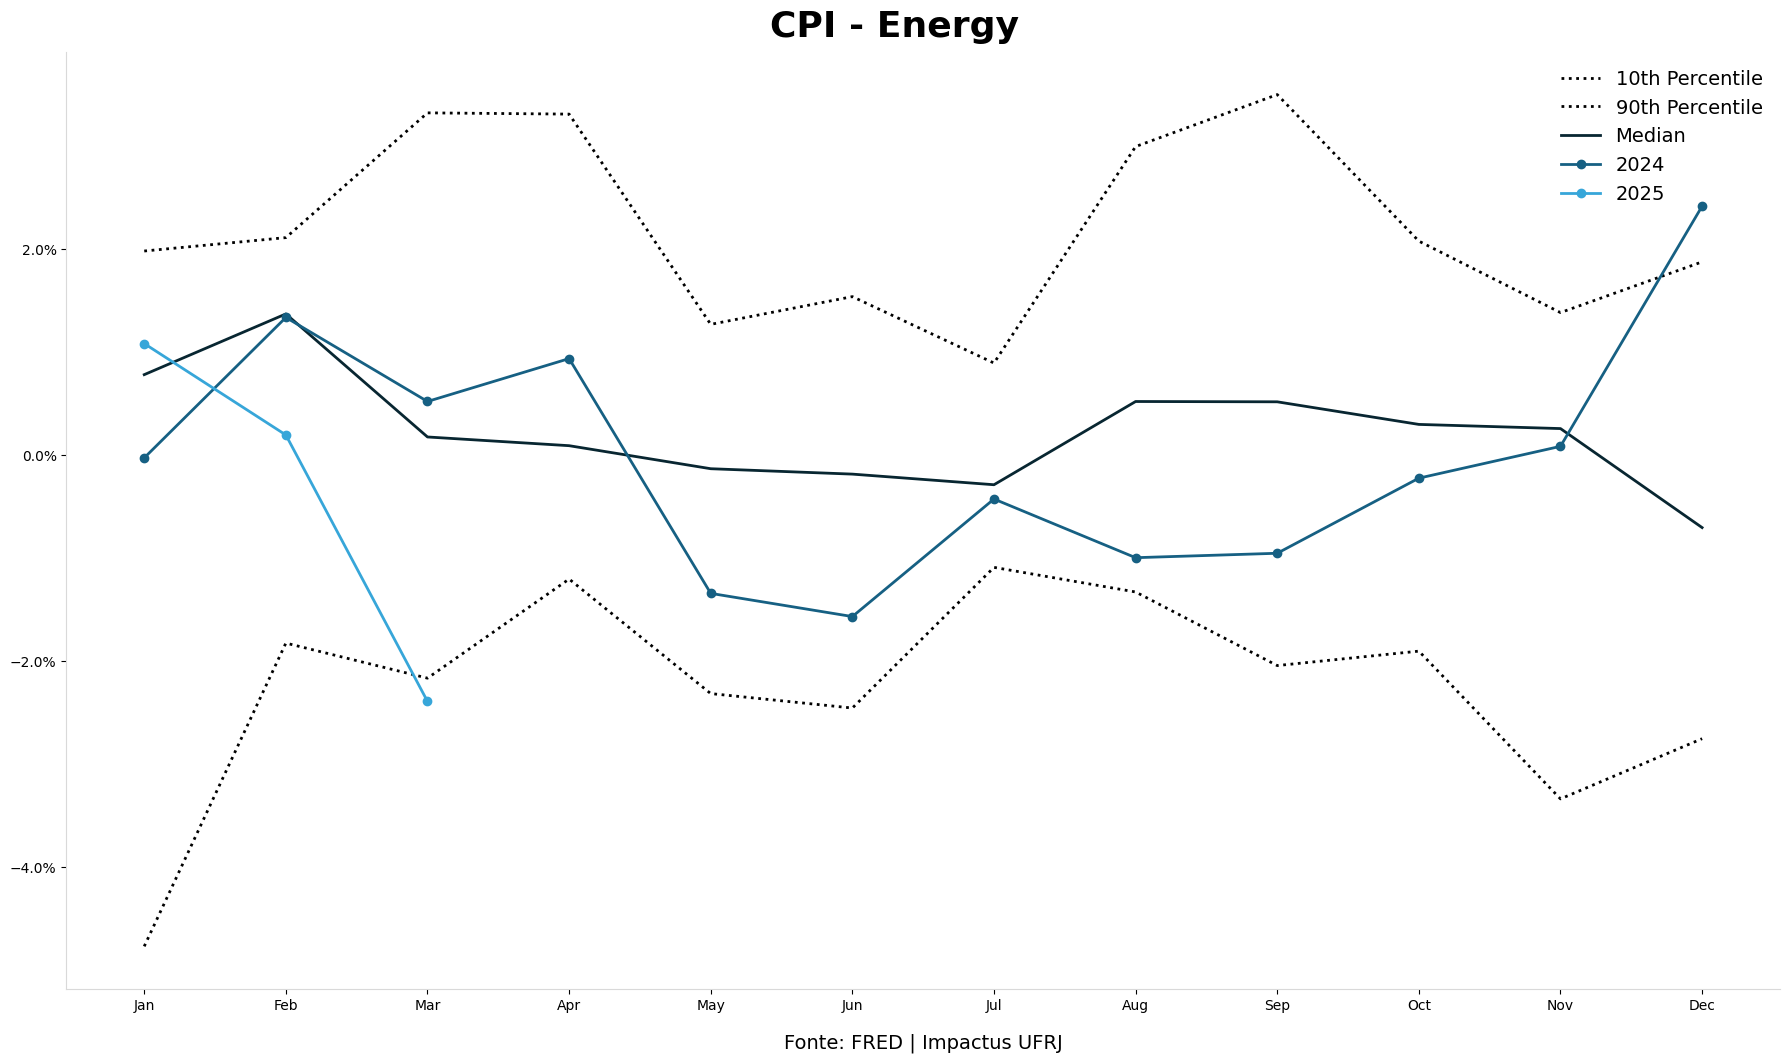

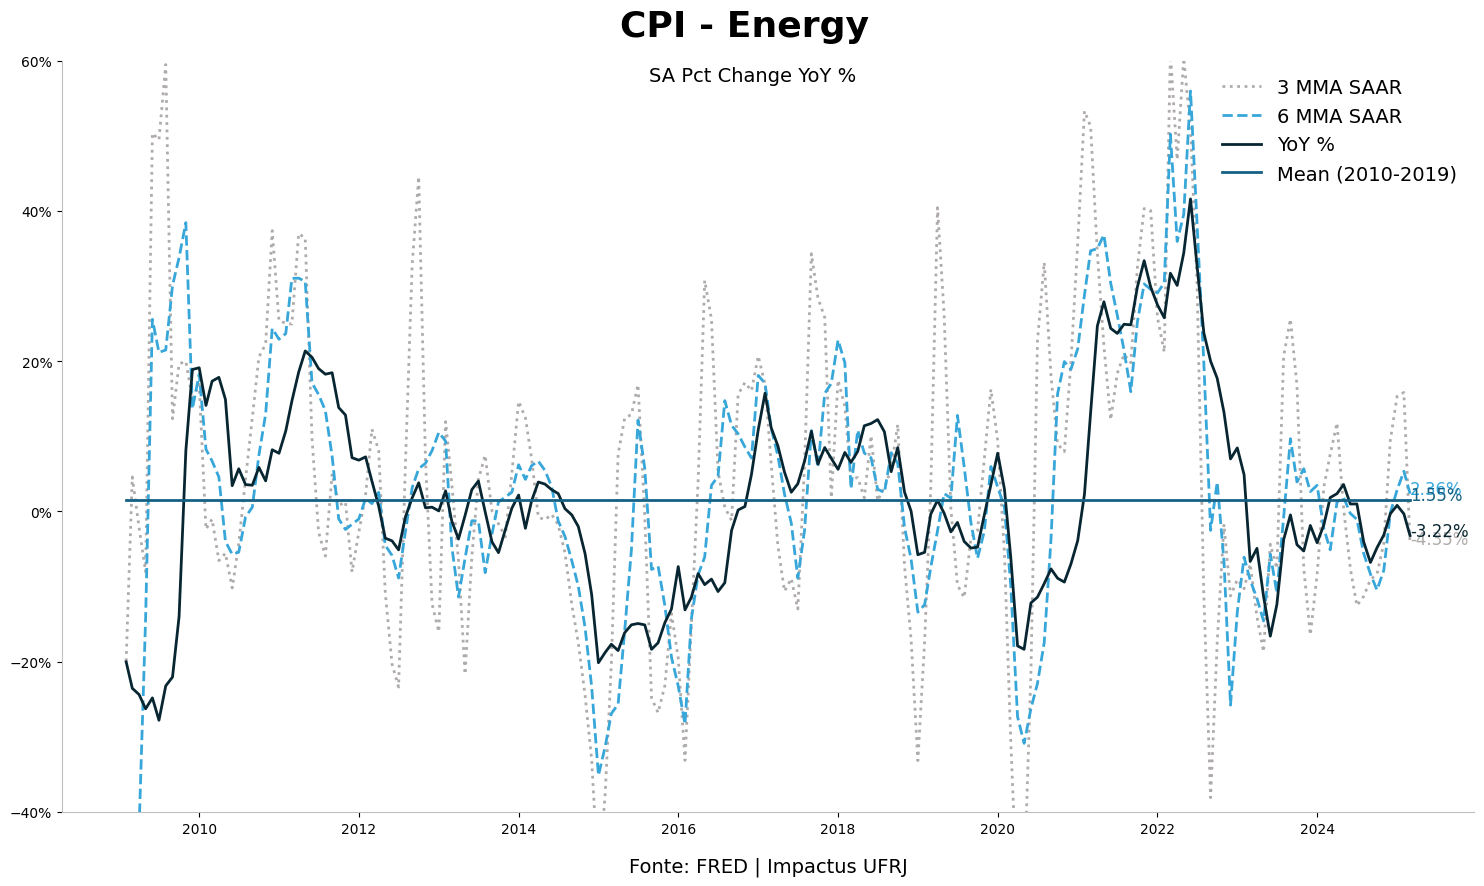

In [31]:
#energy
pc = fred.get_series("CPIENGSL")
cpi_energy = pd.DataFrame()
cpi_energy["Nível de preços"] = pd.DataFrame(pc)
cpi_energy["Pct Change"] = cpi_energy['Nível de preços'].pct_change()
cpi_energy["Pct Change from a year ago"] = cpi_energy['Nível de preços'].pct_change(periods=12)
graf_sa_energy = sa_main(cpi_energy, titulo= "CPI - Energy")
graf_sa_ya = anualizar(cpi_energy, titulo= "CPI - Energy", ylim=(-0.4, 0.6))
plt.show(graf_sa_energy)
